<a href="https://colab.research.google.com/github/mohitbt66/Credit-Card-Fraud-Detection-using-Machine-Learning/blob/main/Renewable_Power_Generation_Forecasting_Using_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import math

# Data preprocessing
from sklearn.model_selection import train_test_split    # Splitting datasets
from sklearn.model_selection import TimeSeriesSplit     # cross-validation

# Feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler    # Feature scaling

# Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, Lambda, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
from sklearn.svm import SVR

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Manage warning messages
import warnings
warnings.filterwarnings('ignore')   # Ignore all warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Download datasets from Kaggle

! kaggle datasets download anikannal/solar-power-generation-data

Dataset URL: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data
License(s): copyright-authors


In [ ]:
# Unzip dataset zip file

! unzip solar-power-generation-data.zip

Archive:  solar-power-generation-data.zip
  inflating: Plant_1_Generation_Data.csv  
  inflating: Plant_1_Weather_Sensor_Data.csv  
  inflating: Plant_2_Generation_Data.csv  
  inflating: Plant_2_Weather_Sensor_Data.csv  


In [ ]:
# Read the .CSV files into Pandas dataframe
df_p1_gen = pd.read_csv('/content/Plant_1_Generation_Data.csv')
df_p1_sens = pd.read_csv('/content/Plant_1_Weather_Sensor_Data.csv')
df_p2_gen = pd.read_csv('/content/Plant_2_Generation_Data.csv')
df_p2_sens = pd.read_csv('/content/Plant_2_Weather_Sensor_Data.csv')

df_list = [df_p1_gen, df_p1_sens, df_p2_gen, df_p2_sens]
name_list = ['Plant_1_Generation_Data', 'Plant_1_Weather_Sensor_Data', 'Plant_2_Generation_Data', 'Plant_2_Weather_Sensor_Data']

**Exploratory Data Analysis**

In [ ]:
for df in df_list:
    print(df.head(3))

          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
             DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
             DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1  2020-

In [ ]:
for df in df_list:
    print(f"This dataset has \033[1m{df.shape[0]}\033[0m rows and \033[1m{df.shape[1]}\033[0m columns.")

This dataset has 68778 rows and 7 columns.
This dataset has 3182 rows and 6 columns.
This dataset has 67698 rows and 7 columns.
This dataset has 3259 rows and 6 columns.


In [ ]:
for df in df_list:
    print(df.info())
    print("\033[1mMissing values and duplicate values in dataset\033[0m")
    print(df.isna().sum().sum())
    print(df.duplicated().sum())
    print('-------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
None
Missing values and duplicate values in dataset
0
0
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   obje

In [ ]:
for df in df_list:
    print(df.describe())

        PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD
count    68778.0  68778.000000  68778.000000  68778.000000  6.877800e+04
mean   4135001.0   3147.426211    307.802752   3295.968737  6.978712e+06
std          0.0   4036.457169    394.396439   3145.178309  4.162720e+05
min    4135001.0      0.000000      0.000000      0.000000  6.183645e+06
25%    4135001.0      0.000000      0.000000      0.000000  6.512003e+06
50%    4135001.0    429.000000     41.493750   2658.714286  7.146685e+06
75%    4135001.0   6366.964286    623.618750   6274.000000  7.268706e+06
max    4135001.0  14471.125000   1410.950000   9163.000000  7.846821e+06
        PLANT_ID  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
count     3182.0          3182.000000         3182.000000  3182.000000
mean   4135001.0            25.531606           31.091015     0.228313
std          0.0             3.354856           12.261222     0.300836
min    4135001.0            20.398505           18.140415  

Columns for the two "generation" datasets and the two "weather sensor" datasets are identical.

In [ ]:
print('\033[1mThe two "Generation" datasets contain identical columns:\033[0m\n')
print(df_p1_gen.columns == df_p2_gen.columns,'\n')
print(df_p1_gen.columns)
print('')
print('\033[1mThe two "Weather Sensor" datasets contain identical columns:\033[0m\n')
print(df_p1_sens.columns == df_p2_sens.columns,'\n')
print(df_p1_sens.columns)

The two "Generation" datasets contain identical columns:

[ True  True  True  True  True  True  True] 

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD'],
      dtype='object')

The two "Weather Sensor" datasets contain identical columns:

[ True  True  True  True  True  True] 

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION'],
      dtype='object')


"Date-Time" columns for the datasets need to be converted to "datetime64" format:

In [ ]:
print(f"for all datasets, the 'Date_Time' column has \033[1m{df_p1_gen.dtypes['DATE_TIME']}\033[0m type.")
#To convert them to "date and time" format:
df_list[0]['DATE_TIME'] = pd.to_datetime(df_list[0]['DATE_TIME'], dayfirst=True).dt.strftime('%Y-%m-%d %H:%M:%S')
for df in df_list:
    print(df.iloc[0,0])
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
print(f"\nNow the 'Date_Time' columns in all data sets have \033[1m{df_p1_gen.dtypes['DATE_TIME']}\033[0m format")
for df in df_list:
    print(df.iloc[0,0])

for all datasets, the 'Date_Time' column has object type.
2020-05-15 00:00:00
2020-05-15 00:00:00
2020-05-15 00:00:00
2020-05-15 00:00:00

Now the 'Date_Time' columns in all data sets have datetime64[ns] format
2020-05-15 00:00:00
2020-05-15 00:00:00
2020-05-15 00:00:00
2020-05-15 00:00:00


Let us check the date range for all the datasets:

In [ ]:
for i in range(len(name_list)):
    print(f"{name_list[i]}'s start date is \033[1m{df_list[i].iloc[0].loc['DATE_TIME']}\033[0m and final date is \033[1m{df_list[i].iloc[-1].loc['DATE_TIME']}\033[0m.\n")

Plant_1_Generation_Data's start date is 2020-05-15 00:00:00 and final date is 2020-06-17 23:45:00.

Plant_1_Weather_Sensor_Data's start date is 2020-05-15 00:00:00 and final date is 2020-06-17 23:45:00.

Plant_2_Generation_Data's start date is 2020-05-15 00:00:00 and final date is 2020-06-17 23:45:00.

Plant_2_Weather_Sensor_Data's start date is 2020-05-15 00:00:00 and final date is 2020-06-17 23:45:00.



The date range for all 4 datasets are identical.

The 4 datasets start on 2020-05-15 midnight and end on 2020-06-17 23:45:00.

Let's check the rows as per time stamp:

In [ ]:
for i in range(len(df_list)):
    print(f"{name_list[i]}: \n-----\n{df_list[i].groupby('DATE_TIME').count()['PLANT_ID'].value_counts()}\n")

Plant_1_Generation_Data: 
-----
PLANT_ID
22    3057
10      32
21      27
14      23
18      14
4        2
20       1
16       1
19       1
Name: count, dtype: int64

Plant_1_Weather_Sensor_Data: 
-----
PLANT_ID
1    3182
Name: count, dtype: int64

Plant_2_Generation_Data: 
-----
PLANT_ID
22    2355
18     840
12      64
Name: count, dtype: int64

Plant_2_Weather_Sensor_Data: 
-----
PLANT_ID
1    3259
Name: count, dtype: int64



The two "generation" datasets contain different number of rows (mainly 22 rows) for every 15 minutes time stamp.

For "weather sensor" datasets, there is only 1 row per each 15 minutes time stamp.

For some of the future analysis, we group the "generation" datasets based on the average of every 15 min data.

In [ ]:
df_group = []
df_group.append(df_list[0].groupby('DATE_TIME').mean(numeric_only=True).reset_index())
df_group.append(df_list[1])
df_group.append(df_list[2].groupby('DATE_TIME').mean(numeric_only=True).reset_index())
df_group.append(df_list[3])

In [ ]:
for i in range(len(df_list)):
    print(f"{name_list[i]}: \n-----\n{df_group[i].groupby('DATE_TIME').count()['PLANT_ID'].value_counts()}\n")

Plant_1_Generation_Data: 
-----
PLANT_ID
1    3158
Name: count, dtype: int64

Plant_1_Weather_Sensor_Data: 
-----
PLANT_ID
1    3182
Name: count, dtype: int64

Plant_2_Generation_Data: 
-----
PLANT_ID
1    3259
Name: count, dtype: int64

Plant_2_Weather_Sensor_Data: 
-----
PLANT_ID
1    3259
Name: count, dtype: int64



Now, all datasets contain 1 row per 15 minutes timestamp.

Extract "DATE" from "DATE-TIME" column and store them in separate columns:

In [ ]:
for df in df_group:
    df['DATE'] = df['DATE_TIME'].dt.strftime('%Y-%m-%d')
    df['DATE'] = df['DATE_TIME'].dt.normalize()

In [ ]:
for df in df_group:
    print(df.head(2))

            DATE_TIME   PLANT_ID  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15 00:00:00  4135001.0       0.0       0.0          0.0   
1 2020-05-15 00:15:00  4135001.0       0.0       0.0          0.0   

    TOTAL_YIELD       DATE  
0  6.837223e+06 2020-05-15  
1  6.837223e+06 2020-05-15  
            DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1 2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   

   MODULE_TEMPERATURE  IRRADIATION       DATE  
0           22.857507          0.0 2020-05-15  
1           22.761668          0.0 2020-05-15  
            DATE_TIME   PLANT_ID  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15 00:00:00  4136001.0       0.0       0.0  2222.724459   
1 2020-05-15 00:15:00  4136001.0       0.0       0.0  1290.954545   

    TOTAL_YIELD       DATE  
0  6.449816e+08 2020-05-15  
1  6.449816e+08 2020-05-15  
            DATE_TIME  PLANT_ID       SOURCE_K

**Data Exploration and Visualization**

Comparing Ambient and Module Temperature distribution for the two Solar Plants:

First, concatenate the two "weather sensor" datasets in one dataset:

In [ ]:
concat_weather = pd.concat([df_group[1], df_group[3]], ignore_index=True)

In [ ]:
concat_weather

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0    2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1    2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2    2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3    2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4    2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   
...                  ...       ...              ...                  ...   
6436 2020-06-17 22:45:00   4136001  iq8k7ZNt4Mwm3w0            23.511703   
6437 2020-06-17 23:00:00   4136001  iq8k7ZNt4Mwm3w0            23.482282   
6438 2020-06-17 23:15:00   4136001  iq8k7ZNt4Mwm3w0            23.354743   
6439 2020-06-17 23:30:00   4136001  iq8k7ZNt4Mwm3w0            23.291048   
6440 2020-06-17 23:45:00   4136001  iq8k7ZNt4Mwm3w0            23.202871   

      MODULE_TEMPERATURE  IRRADIATION       DATE  
0              22.857507          0.0 2020-05-15  
1              22.761668          0.0 2020-05-15  
2              22.592306          0.0 2020-05-15  
3              22.360852          0.0 2020-05-15  
4              22.165423          0.0 2020-05-15  
...                  ...          ...        ...  
6436           22.856201          0.0 2020-06-17  
6437           22.744190          0.0 2020-06-17  
6438           22.492245          0.0 2020-06-17  
6439           22.373909          0.0 2020-06-17  
6440           22.535908          0.0 2020-06-17  

[6441 rows x 7 columns]

Second, plot the ambient and module temperature for the two datasets using seaborn displot:

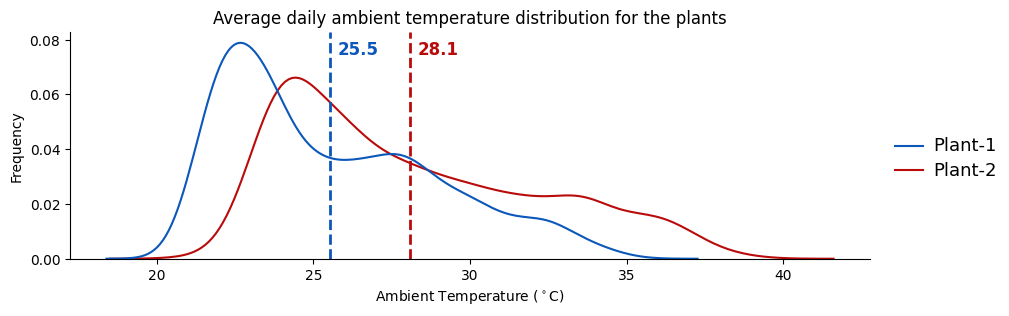

In [ ]:
g = sns.displot(data=concat_weather,x='AMBIENT_TEMPERATURE',kind='kde',hue='PLANT_ID',height=3, aspect=3, palette=['#0b57ba','#ba0b0b'])
new_labels = ['Plant-1', 'Plant-2']
g._legend.set_title(None)
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
for text in g._legend.texts:
    text.set_fontsize(13)
plt.axvline(df_group[1]['AMBIENT_TEMPERATURE'].mean(), color='#0b57ba', lw=2, ls='--')
plt.axvline(df_group[3]['AMBIENT_TEMPERATURE'].mean(), color='#ba0b0b', lw=2, ls='--')
plt.text(
    df_group[1]['AMBIENT_TEMPERATURE'].mean() + 0.25,  # Adjust horizontal position slightly
    plt.ylim()[1] * 0.9,  # Position text near the top
    f'{df_group[1]["AMBIENT_TEMPERATURE"].mean():.1f}',  # Format to 2 decimal places
    color='#0b57ba',
    fontsize=12,
    fontweight='bold'
)
plt.text(
    df_group[3]['AMBIENT_TEMPERATURE'].mean() + 0.25,  # Adjust horizontal position slightly
    plt.ylim()[1] * 0.9,  # Position text near the top
    f'{df_group[3]["AMBIENT_TEMPERATURE"].mean():.1f}',  # Format to 2 decimal places
    color='#ba0b0b',
    fontsize=12,
    fontweight='bold'
)
plt.xlabel('Ambient Temperature ($^\circ$C)')
plt.ylabel('Frequency')
plt.title('Average daily ambient temperature distribution for the plants')
plt.show()

Plant-2 in average experienced 2.6° C higher ambient temperature than Plant-1.

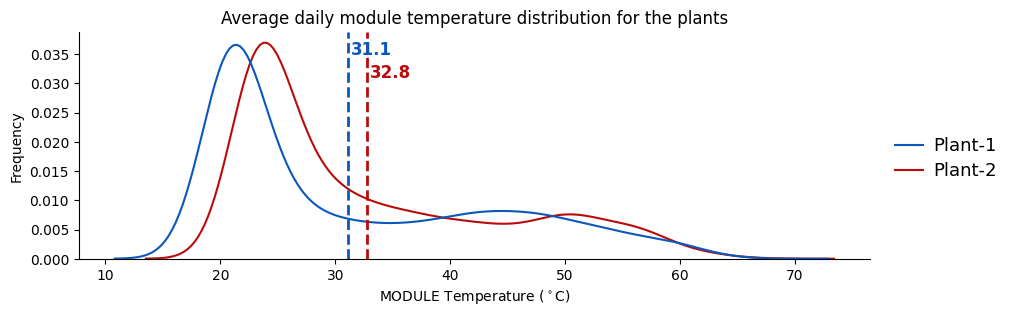

In [ ]:
g = sns.displot(data=concat_weather,x='MODULE_TEMPERATURE',kind='kde',hue='PLANT_ID',height=3, aspect=3, palette=['#0b57ba','#ba0b0b'])
new_labels = ['Plant-1', 'Plant-2']
g._legend.set_title(None)
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
for text in g._legend.texts:
    text.set_fontsize(13)
plt.axvline(df_group[1]['MODULE_TEMPERATURE'].mean(), color='#0b57ba', lw=2, ls='--')
plt.axvline(df_group[3]['MODULE_TEMPERATURE'].mean(), color='#ba0b0b', lw=2, ls='--')
plt.text(
    df_group[1]['MODULE_TEMPERATURE'].mean() + 0.25,  # Adjust horizontal position slightly
    plt.ylim()[1] * 0.9,  # Position text near the top
    f'{df_group[1]["MODULE_TEMPERATURE"].mean():.1f}',  # Format to 2 decimal places
    color='#0b57ba',
    fontsize=12,
    fontweight='bold'
)
plt.text(
    df_group[3]['MODULE_TEMPERATURE'].mean() + 0.25,  # Adjust horizontal position slightly
    plt.ylim()[1] * 0.8,  # Position text near the top
    f'{df_group[3]["MODULE_TEMPERATURE"].mean():.1f}',  # Format to 2 decimal places
    color='#ba0b0b',
    fontsize=12,
    fontweight='bold'
)
plt.xlabel('MODULE Temperature ($^\circ$C)')
plt.ylabel('Frequency')
plt.title('Average daily module temperature distribution for the plants')
plt.show()

Plant-2 in average experienced 1.7° C higher module temperature than Plant-1.

Comparing ambient and module temperature for each plant.

First, averaging datasets by "date" column to obtain average daily temperatures.



In [ ]:
df_daily_temp_plant_1 = df_group[1].groupby('DATE').mean(numeric_only=True).reset_index()
df_daily_temp_plant_2 = df_group[3].groupby('DATE').mean(numeric_only=True).reset_index()

In [ ]:
df_daily_temp_plant_1.head(2)

DATE   PLANT_ID  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
0 2020-05-15  4135001.0            27.430823           32.582964     0.204699
1 2020-05-16  4135001.0            26.780538           31.858851     0.211951

Plant-1

Average module temperature is 5.6° C higher than average ambient temperature.

In [ ]:
print(f"Correlation factor for ambient and module temperature for Plant-1 are: {round(df_daily_temp_plant_1['AMBIENT_TEMPERATURE'].corr(df_daily_temp_plant_1['MODULE_TEMPERATURE']),3)}")

Correlation factor for ambient and module temperature for Plant-1 are: 0.891


The ambient and module daily temperature somehow correlated, which means changes in the module temperature are likely due to changes in the ambient temperature.

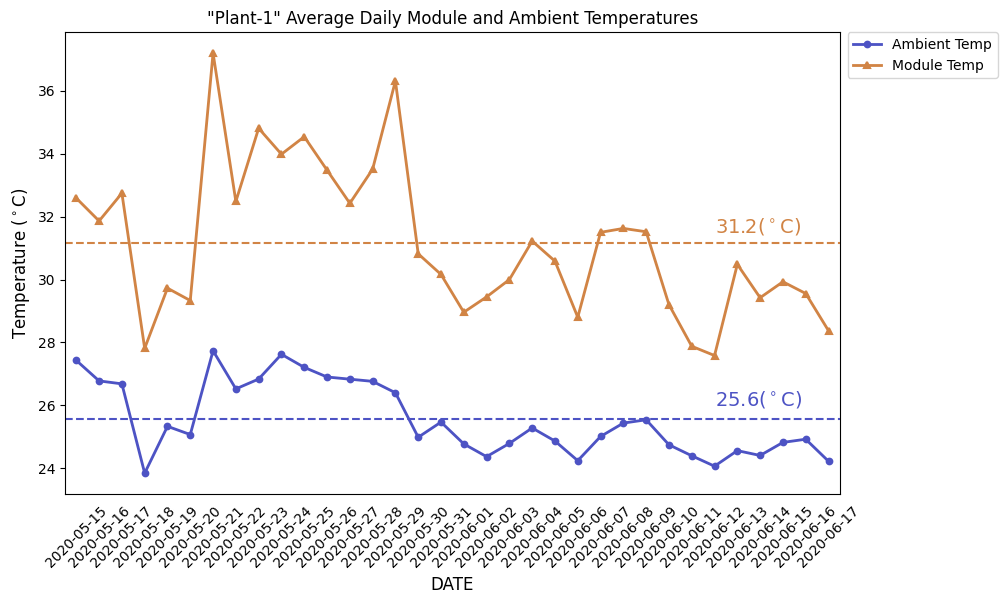

In [ ]:
plt.figure(figsize=(10, 6))
fig = sns.pointplot(data=df_daily_temp_plant_1,x='DATE',y='AMBIENT_TEMPERATURE',color='#4d53c4',label='Ambient Temp',scale=0.75)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)


fig.tick_params(bottom=False)

fig = sns.pointplot(data=df_daily_temp_plant_1,x='DATE',y='MODULE_TEMPERATURE',color='#d18445',label='Module Temp',markers='^',scale=0.75)

fig.tick_params(bottom=False)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Temperature ($^\circ$C)', fontsize=12)

plt.xticks(rotation=45)
plt.xlabel('DATE', fontsize=12)
plt.title('"Plant-1" Average Daily Module and Ambient Temperatures')
plt.axhline(y = round(np.average(df_daily_temp_plant_1['AMBIENT_TEMPERATURE']),2), color = '#4d53c4', linestyle = 'dashed')
plt.axhline(y = round(np.average(df_daily_temp_plant_1['MODULE_TEMPERATURE']),2), color = '#d18445', linestyle = 'dashed')

plt.text(28, 26, f"{round(np.average(df_daily_temp_plant_1['AMBIENT_TEMPERATURE']),1)}($^\circ$C)", fontsize = 14,color='#4d53c4')
plt.text(28, 31.5, f"{round(np.average(df_daily_temp_plant_1['MODULE_TEMPERATURE']),1)}($^\circ$C)", fontsize = 14,color='#d18445')
plt.show()

Plant-2

Average module temperature is 4.7° C higher than average ambient temperature.

In [ ]:
print(f"Correlation factor for ambient and module temperatures for Plant-2 are: {round(df_daily_temp_plant_2['AMBIENT_TEMPERATURE'].corr(df_daily_temp_plant_2['MODULE_TEMPERATURE']),3)}")

Correlation factor for ambient and module temperatures for Plant-2 are: 0.965


The ambient and module daily temperature are correlated, which means changes in the module temperature are primarily due to changes in the ambient temperature.

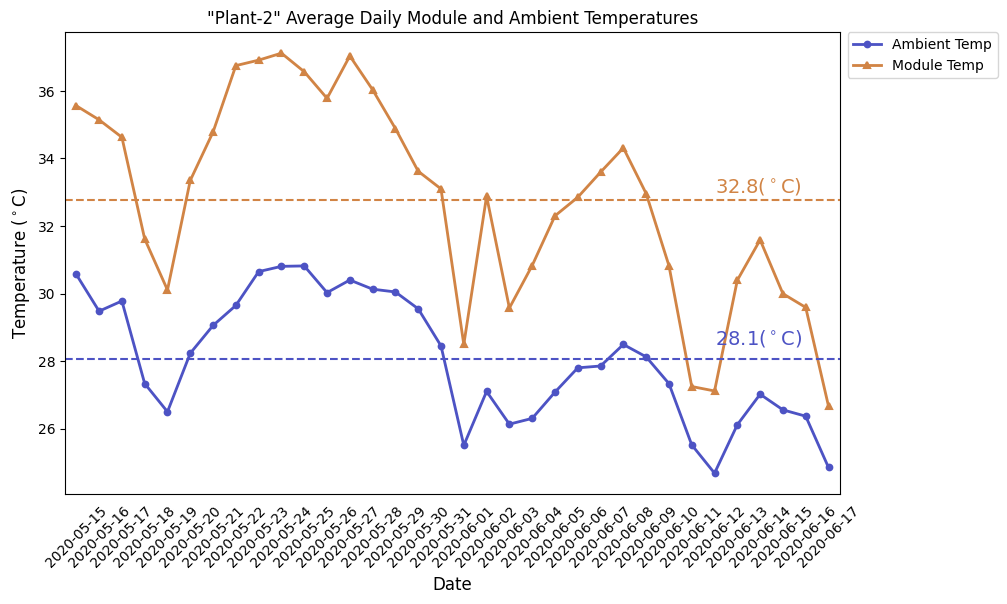

In [ ]:
plt.figure(figsize=(10, 6))
fig = sns.pointplot(data=df_daily_temp_plant_2,x='DATE',y='AMBIENT_TEMPERATURE',color='#4d53c4',label='Ambient Temp',scale=0.75)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

fig.tick_params(bottom=False)

fig = sns.pointplot(data=df_daily_temp_plant_2,x='DATE',y='MODULE_TEMPERATURE',color='#d18445',label='Module Temp',markers='^',scale=0.75)
fig.tick_params(bottom=False)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Temperature ($^\circ$C)', fontsize=12)

plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.title('"Plant-2" Average Daily Module and Ambient Temperatures')
plt.axhline(y = round(np.average(df_daily_temp_plant_2['AMBIENT_TEMPERATURE']),2), color = '#4d53c4', linestyle = 'dashed')
plt.axhline(y = round(np.average(df_daily_temp_plant_2['MODULE_TEMPERATURE']),2), color = '#d18445', linestyle = 'dashed')

plt.text(28, 28.5, f"{round(np.average(df_daily_temp_plant_2['AMBIENT_TEMPERATURE']),1)}($^\circ$C)", fontsize = 14,color='#4d53c4')
plt.text(28, 33, f"{round(np.average(df_daily_temp_plant_2['MODULE_TEMPERATURE']),1)}($^\circ$C)", fontsize = 14,color='#d18445')
plt.show()

Evaluating Daily Yield of each plant:

In [ ]:
df_daily_yield = [df_group[0].groupby('DATE').max('DAILY_YIELD').reset_index(),df_group[2].groupby('DATE').max('DAILY_YIELD').reset_index()]

In [ ]:
print(f"Average daily yield for plant-1 is: {round(np.average(df_daily_yield[0]['DAILY_YIELD']),2)}")
print(f"Average daily yield for plant-2 is: {round(np.average(df_daily_yield[1]['DAILY_YIELD']),2)}")

print(f"The average daily yield for plant-1 is {round((np.average(df_daily_yield[0]['DAILY_YIELD'])-np.average(df_daily_yield[1]['DAILY_YIELD']))/(np.average(df_daily_yield[1]['DAILY_YIELD'])),2)*100}% higher than plant-2")

Average daily yield for plant-1 is: 7196.59
Average daily yield for plant-2 is: 5949.21
The average daily yield for plant-1 is 21.0% higher than plant-2


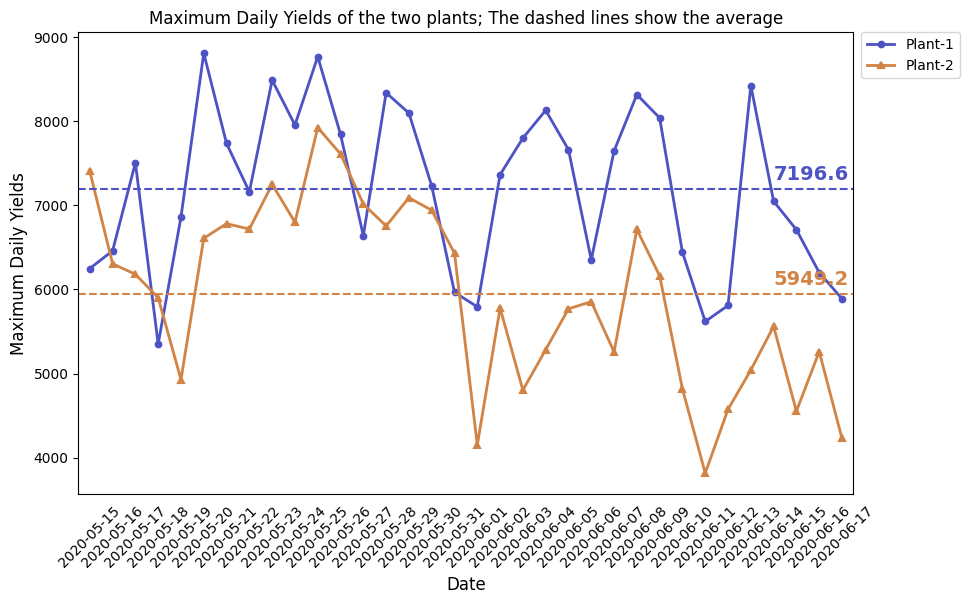

In [ ]:
plt.figure(figsize=(10, 6))
fig = sns.pointplot(data=df_daily_yield[0],x='DATE',y='DAILY_YIELD',color='#4d53c4',label='Plant-1',scale=0.75)
fig = sns.pointplot(data=df_daily_yield[1],x='DATE',y='DAILY_YIELD',color='#d18445',label='Plant-2',markers='^',scale=0.75)

plt.axhline(y = round(np.average(df_daily_yield[0]['DAILY_YIELD']),2), color = '#4d53c4', linestyle = 'dashed', linewidth=1.5)
plt.axhline(y = round(np.average(df_daily_yield[1]['DAILY_YIELD']),2), color = '#d18445', linestyle = 'dashed', linewidth=1.5)

plt.text(30, 7300, f"{round(np.average(df_daily_yield[0]['DAILY_YIELD']),1)}", fontsize = 14,color='#4d53c4', fontweight='bold')
plt.text(30, 6050, f"{round(np.average(df_daily_yield[1]['DAILY_YIELD']),1)}", fontsize = 14,color='#d18445', fontweight='bold')

fig.tick_params(bottom=False)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Maximum Daily Yields', fontsize=12)
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.title('Maximum Daily Yields of the two plants; The dashed lines show the average')

plt.show()

Effect of temperature on yield:

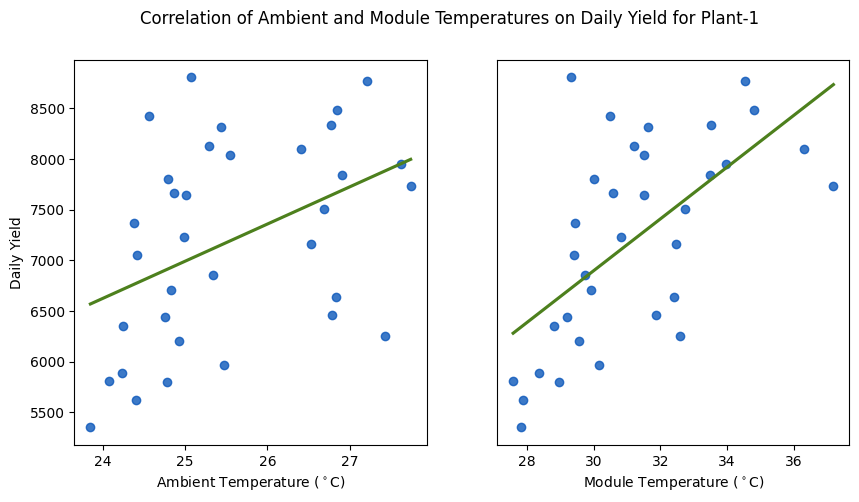

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Correlation of Ambient and Module Temperatures on Daily Yield for Plant-1')
sns.regplot(ax=axes[0],x=df_daily_temp_plant_1['AMBIENT_TEMPERATURE'],y=df_daily_yield[0]['DAILY_YIELD'],line_kws=dict(color="#4d801d"),color="#0b57ba",ci = None)
axes[0].set_xlabel('Ambient Temperature ($^\circ$C)')
axes[0].set_ylabel('Daily Yield')
sns.regplot(ax=axes[1],x=df_daily_temp_plant_1['MODULE_TEMPERATURE'],y=df_daily_yield[0]['DAILY_YIELD'],line_kws=dict(color="#4d801d"),color="#0b57ba",ci = None)
axes[1].set_xlabel('Module Temperature ($^\circ$C)')
axes[1].get_yaxis().set_visible(False)
plt.show()

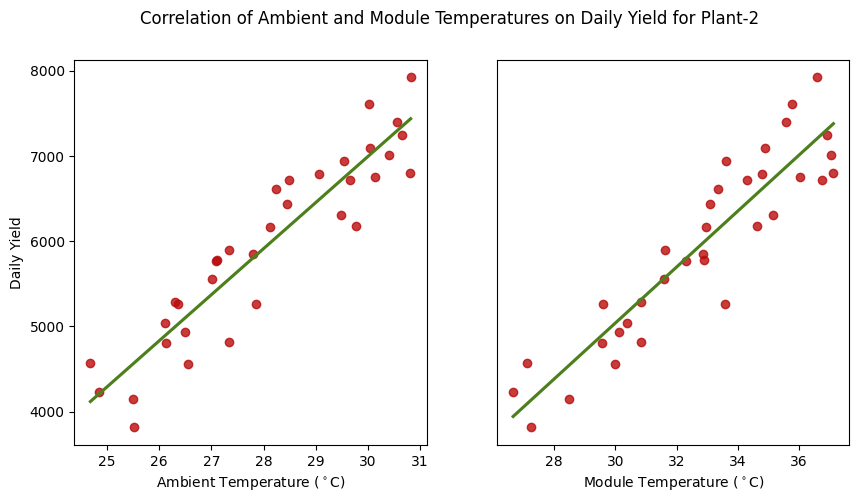

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Correlation of Ambient and Module Temperatures on Daily Yield for Plant-2')
sns.regplot(ax=axes[0],x=df_daily_temp_plant_2['AMBIENT_TEMPERATURE'],y=df_daily_yield[1]['DAILY_YIELD'],line_kws=dict(color="#4d801d"),color="#ba0b0b",ci = None)
axes[0].set_xlabel('Ambient Temperature ($^\circ$C)')
axes[0].set_ylabel('Daily Yield')
sns.regplot(ax=axes[1],x=df_daily_temp_plant_2['MODULE_TEMPERATURE'],y=df_daily_yield[1]['DAILY_YIELD'],line_kws=dict(color="#4d801d"),color="#ba0b0b",ci = None)
axes[1].set_xlabel('Module Temperature ($^\circ$C)')
axes[1].get_yaxis().set_visible(False)
plt.show()

In [ ]:
print('plant-1 \n-----')
print(f"correlation between daily yield and ambient temperature: {round(df_daily_yield[0]['DAILY_YIELD'].corr(df_daily_temp_plant_1['AMBIENT_TEMPERATURE']),3)}")
print(f"correlation between daily yield and module temperature: {round(df_daily_yield[0]['DAILY_YIELD'].corr(df_daily_temp_plant_1['MODULE_TEMPERATURE']),3)}")

plant-1 
-----
correlation between daily yield and ambient temperature: 0.426
correlation between daily yield and module temperature: 0.616


In [ ]:
print('plant-2 \n-----')
print(f"correlation between daily yield and ambient temperature: {round(df_daily_yield[1]['DAILY_YIELD'].corr(df_daily_temp_plant_2['AMBIENT_TEMPERATURE']),3)}")
print(f"correlation between daily yield and module temperature: {round(df_daily_yield[1]['DAILY_YIELD'].corr(df_daily_temp_plant_2['MODULE_TEMPERATURE']),3)}")

plant-2 
-----
correlation between daily yield and ambient temperature: 0.927
correlation between daily yield and module temperature: 0.92


There is no remarkable correlation between the ambient and module temperature and the daily yield in plant-1.
There is a strong correlation between the ambient and module temperature and the daily yield in plant-2.

Effect of Irradiation

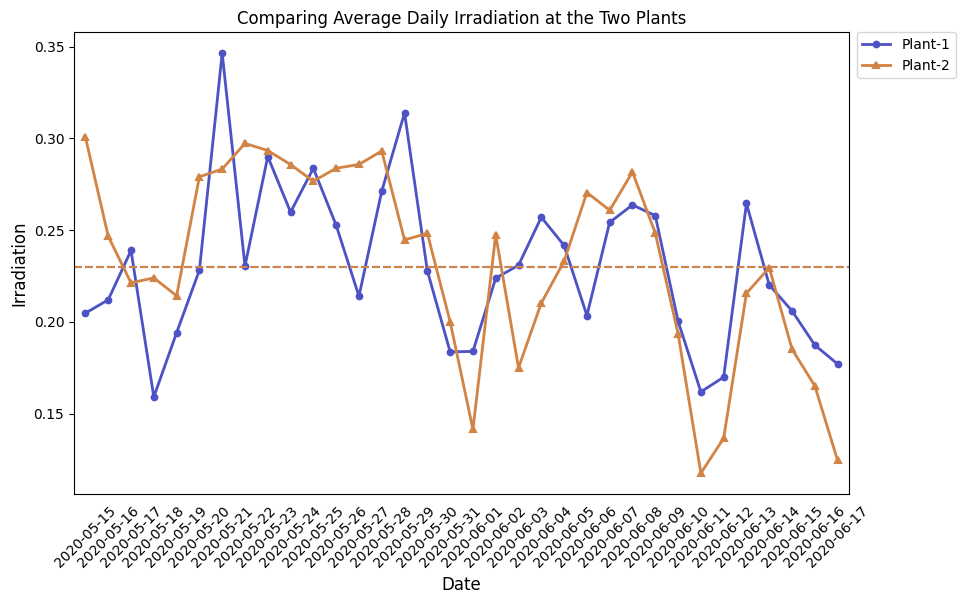

In [ ]:
plt.figure(figsize=(10, 6))
fig = sns.pointplot(data=df_daily_temp_plant_1,x='DATE',y='IRRADIATION',color='#4d53c4',label='Plant-1',scale=0.75)
fig = sns.pointplot(data=df_daily_temp_plant_2,x='DATE',y='IRRADIATION',color='#d18445',label='Plant-2',markers='^',scale=0.75)

fig.tick_params(bottom=False)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Irradiation', fontsize=12)
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.title('Comparing Average Daily Irradiation at the Two Plants')

plt.axhline(y = round(np.average(df_daily_temp_plant_1['IRRADIATION']),2), color = '#4d53c4', linestyle = 'dashed')
plt.axhline(y = round(np.average(df_daily_temp_plant_2['IRRADIATION']),2), color = '#d18445', linestyle = 'dashed')

plt.show()

irradiance vs temperature:

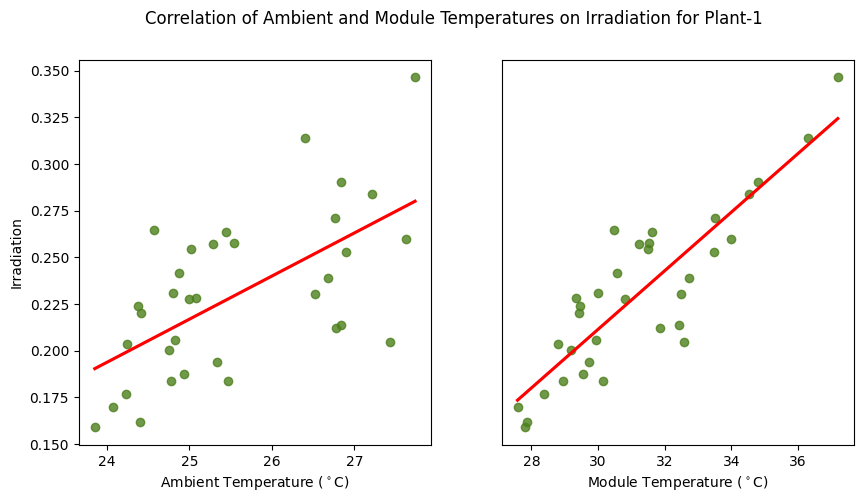

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Correlation of Ambient and Module Temperatures on Irradiation for Plant-1')
sns.regplot(ax=axes[0],x=df_daily_temp_plant_1['AMBIENT_TEMPERATURE'],y=df_daily_temp_plant_1['IRRADIATION'],line_kws=dict(color="r"),color="#4d801d",ci = None)
axes[0].set_xlabel('Ambient Temperature ($^\circ$C)')
axes[0].set_ylabel('Irradiation')
sns.regplot(ax=axes[1],x=df_daily_temp_plant_1['MODULE_TEMPERATURE'],y=df_daily_temp_plant_1['IRRADIATION'],line_kws=dict(color="r"),color="#4d801d",ci = None)
axes[1].set_xlabel('Module Temperature ($^\circ$C)')
axes[1].get_yaxis().set_visible(False)
plt.show()

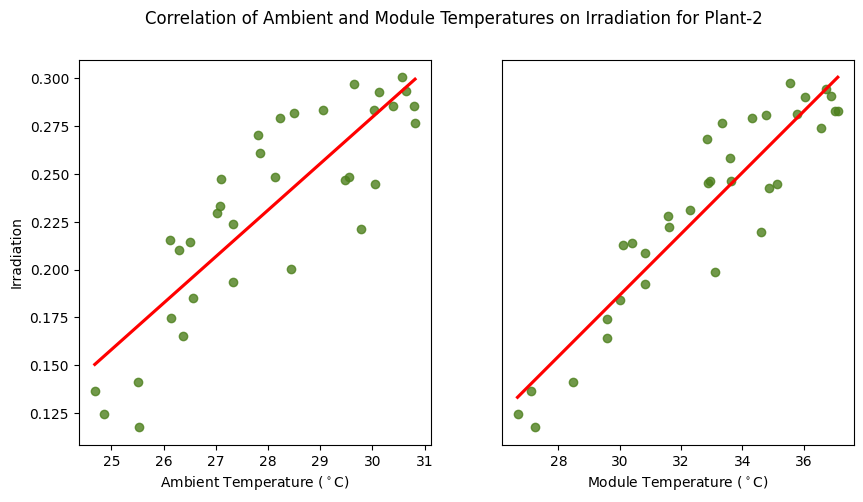

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Correlation of Ambient and Module Temperatures on Irradiation for Plant-2')
sns.regplot(ax=axes[0],x=df_daily_temp_plant_2['AMBIENT_TEMPERATURE'],y=df_daily_temp_plant_2['IRRADIATION'],line_kws=dict(color="r"),color="#4d801d",ci = None)
axes[0].set_xlabel('Ambient Temperature ($^\circ$C)')
axes[0].set_ylabel('Irradiation')
sns.regplot(ax=axes[1],x=df_daily_temp_plant_2['MODULE_TEMPERATURE'],y=df_daily_temp_plant_2['IRRADIATION'],line_kws=dict(color="r"),color="#4d801d",ci = None)
axes[1].set_xlabel('Module Temperature ($^\circ$C)')
axes[1].get_yaxis().set_visible(False)
plt.show()

irradiance vs daily yield

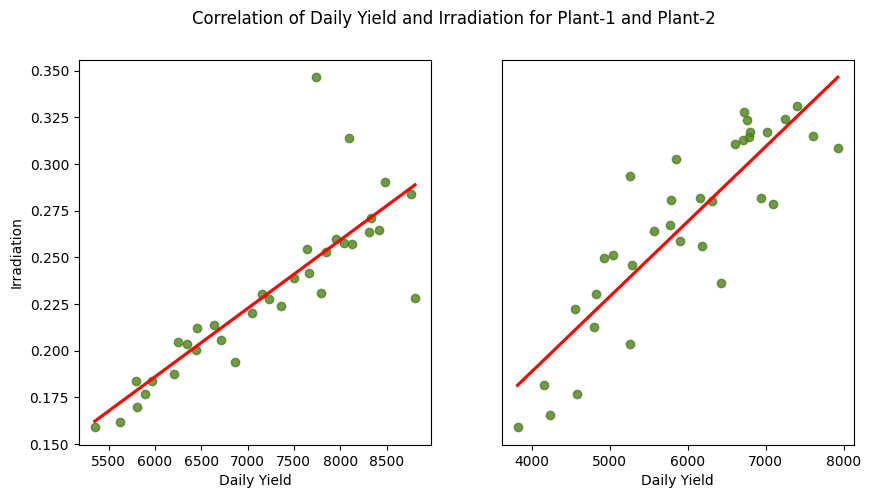

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Correlation of Daily Yield and Irradiation for Plant-1 and Plant-2')
sns.regplot(ax=axes[0],x=df_daily_yield[0]['DAILY_YIELD'],y=df_daily_temp_plant_1['IRRADIATION'],line_kws=dict(color="r"),color="#4d801d",ci = None)
axes[0].set_xlabel('Daily Yield')
axes[0].set_ylabel('Irradiation')
sns.regplot(ax=axes[1],x=df_daily_yield[1]['DAILY_YIELD'],y=df_daily_temp_plant_2['IRRADIATION'],line_kws=dict(color="r"),color="#4d801d",ci = None)
axes[1].set_xlabel('Daily Yield')
axes[1].get_yaxis().set_visible(False)
plt.show()

Now, combine the weather sensor data and generation data for each plant:

In [ ]:
df_plant1 = pd.merge(df_group[0].drop(columns={"PLANT_ID", "DATE"}, axis=1), df_group[1].drop(columns={"PLANT_ID", "SOURCE_KEY", "DATE"}, axis=1), on="DATE_TIME")
df_plant2 = pd.merge(df_group[2].drop(columns={"PLANT_ID", "DATE"}, axis=1), df_group[3].drop(columns={"PLANT_ID", "SOURCE_KEY", "DATE"}, axis=1), on="DATE_TIME")

In [ ]:
df_plant1.head(2)

DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
0 2020-05-15 00:00:00       0.0       0.0          0.0  6.837223e+06   
1 2020-05-15 00:15:00       0.0       0.0          0.0  6.837223e+06   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            25.184316           22.857507          0.0  
1            25.084589           22.761668          0.0

In [ ]:
df_plant2.head(2)

DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
0 2020-05-15 00:00:00       0.0       0.0  2222.724459  6.449816e+08   
1 2020-05-15 00:15:00       0.0       0.0  1290.954545  6.449816e+08   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            27.004764           25.060789          0.0  
1            26.880811           24.421869          0.0

In [ ]:
# Extract DATE and TIME components
df_plant1['DATE'] = df_plant1['DATE_TIME'].dt.day
df_plant1['MONTH'] = df_plant1['DATE_TIME'].dt.month
df_plant1['YEAR'] = df_plant1['DATE_TIME'].dt.year
df_plant1['HOUR'] = df_plant1['DATE_TIME'].dt.hour
df_plant1['MINUTE'] = df_plant1['DATE_TIME'].dt.minute

df_plant2['DATE'] = df_plant2['DATE_TIME'].dt.day
df_plant2['MONTH'] = df_plant2['DATE_TIME'].dt.month
df_plant2['YEAR'] = df_plant2['DATE_TIME'].dt.year
df_plant2['HOUR'] = df_plant2['DATE_TIME'].dt.hour
df_plant2['MINUTE'] = df_plant2['DATE_TIME'].dt.minute

# Extract Day of the Week
df_plant1['DAY_OF_WEEK'] = df_plant1['DATE_TIME'].dt.dayofweek  # 0=Monday, 6=Sunday
df_plant2['DAY_OF_WEEK'] = df_plant2['DATE_TIME'].dt.dayofweek

# Create Day/Night Feature (Assuming Irradiation > 0 means daytime)
df_plant1['DAY_NIGHT'] = (df_plant1['IRRADIATION'] > 0).astype(int)
df_plant2['DAY_NIGHT'] = (df_plant2['IRRADIATION'] > 0).astype(int)

# Drop original DATE_TIME column
df_plant1.drop(columns=['DATE_TIME'], inplace=True)
df_plant2.drop(columns=['DATE_TIME'], inplace=True)

The variables most strongly related to Power Output are: Irradiation, Module Temperature and Ambient Temperature.

In [ ]:
# Creating Lag Features (e.g., using 3 previous time steps)
num_lags = 3
for lag in range(1, num_lags + 1):
    df_plant1[f'AC_POWER_LAG_{lag}'] = df_plant1['AC_POWER'].shift(lag)

# Drop NaN rows introduced by shifting
df_plant1 = df_plant1.dropna()

num_lags = 3
for lag in range(1, num_lags + 1):
    df_plant2[f'AC_POWER_LAG_{lag}'] = df_plant2['AC_POWER'].shift(lag)

# Drop NaN rows introduced by shifting
df_plant2 = df_plant2.dropna()

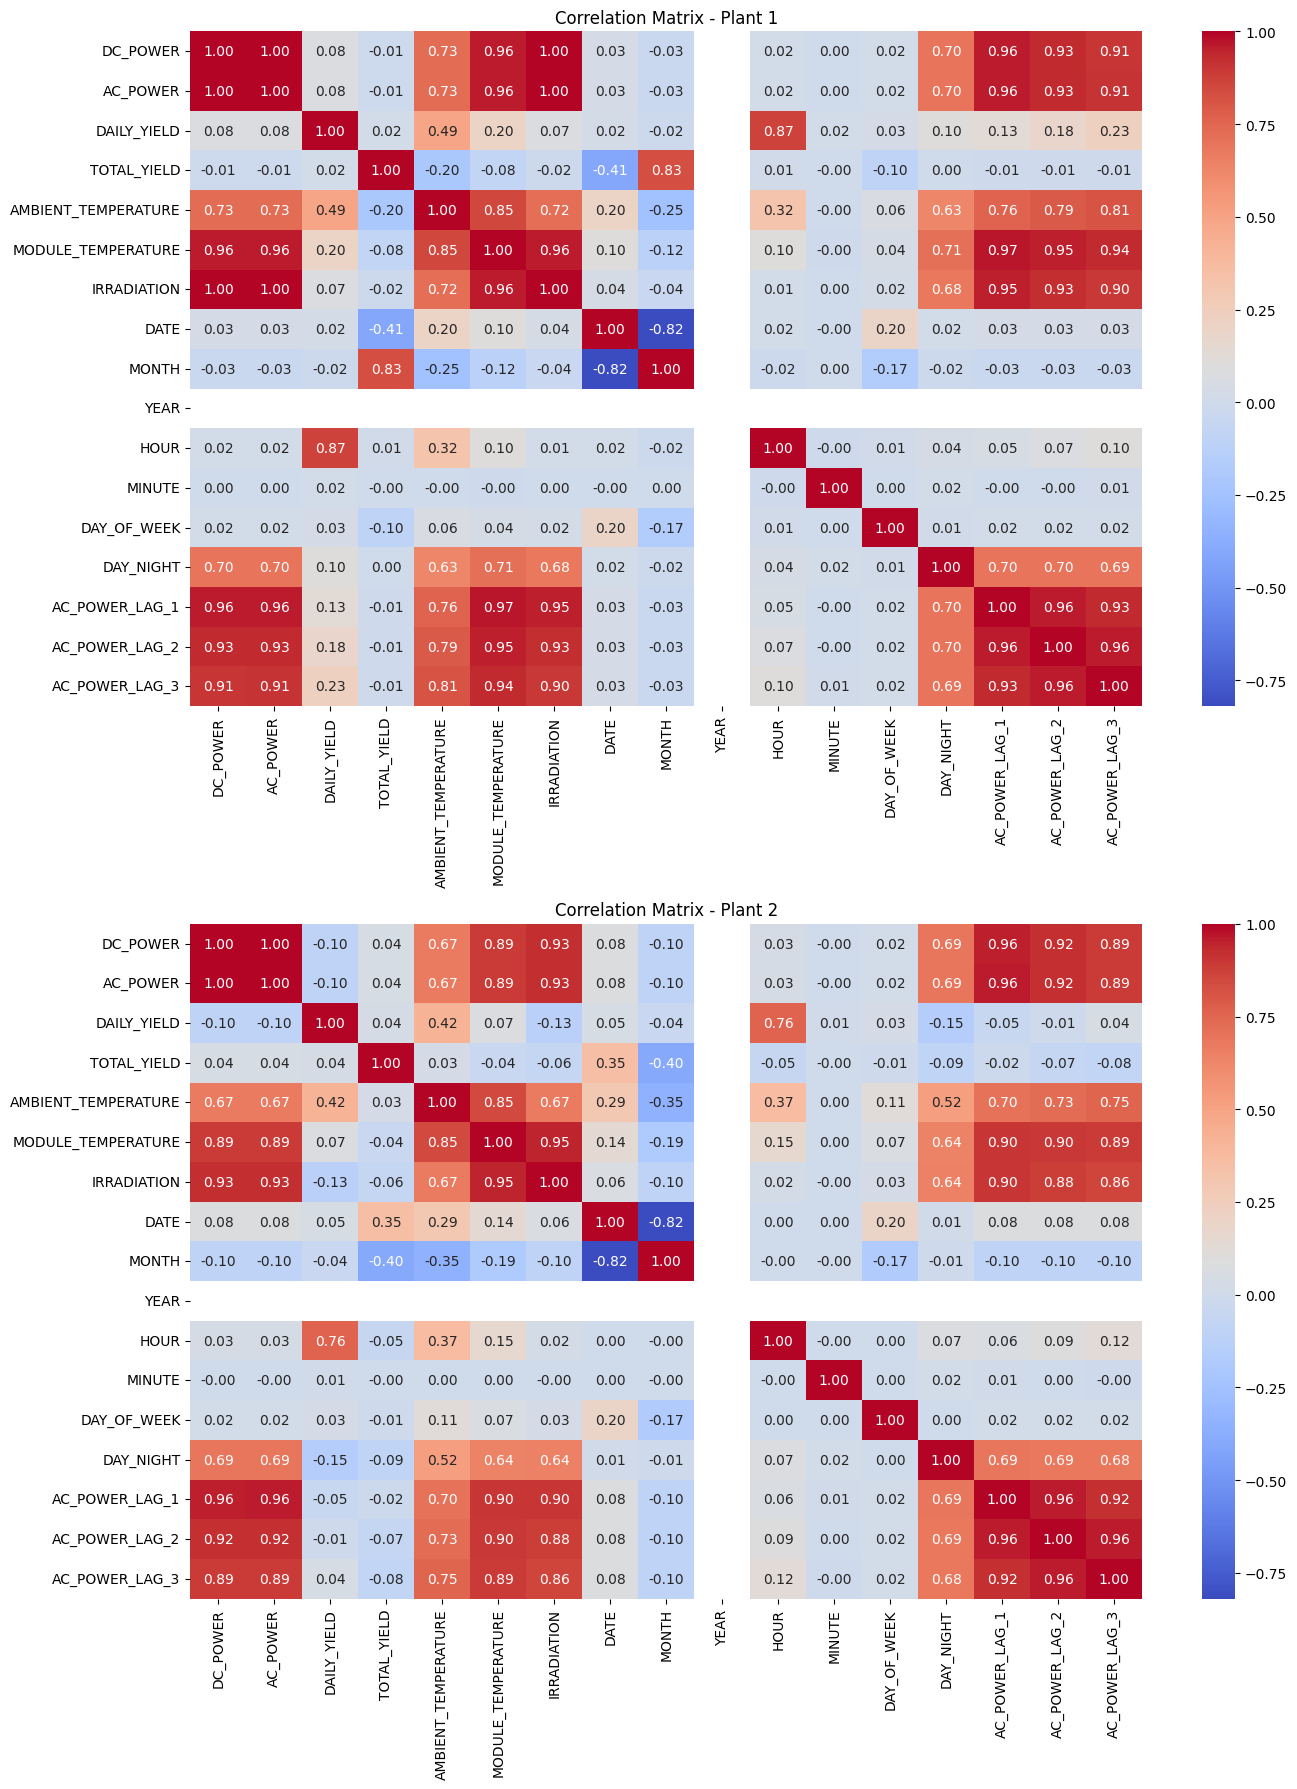

In [ ]:
# Compute correlation matrices
corr_plant1 = df_plant1.corr(numeric_only=True)
corr_plant2 = df_plant2.corr(numeric_only=True)

# Plot heatmaps for better visualization (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(14, 18))  # 2 rows, 1 column

# Plant 1 Correlation Heatmap
sns.heatmap(corr_plant1, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation Matrix - Plant 1")

# Plant 2 Correlation Heatmap
sns.heatmap(corr_plant2, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation Matrix - Plant 2")

plt.tight_layout()
plt.show()

In [ ]:
# Separate features and labels
df_plant1_features = df_plant1.drop('AC_POWER', axis=1)
df_plant1_labels = df_plant1['AC_POWER']

df_plant2_features = df_plant2.drop('AC_POWER', axis=1)
df_plant2_labels = df_plant2['AC_POWER']

In [ ]:
# Splitting the dataset

X_train1, X_test1, y_train1, y_test1 = train_test_split(df_plant1_features, df_plant1_labels, test_size=0.2, shuffle=False)

X_train2, X_test2, y_train2, y_test2 = train_test_split(df_plant2_features, df_plant2_labels, test_size=0.2, shuffle=False)

In [ ]:
# Feature scaling

# Standard Scaling for Plant 1
scaler_x1_standard = StandardScaler()
X_train1_standard = scaler_x1_standard.fit_transform(X_train1)
X_test1_standard = scaler_x1_standard.transform(X_test1)

scaler_y1_standard = StandardScaler()
y_train1_standard = scaler_y1_standard.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_standard = scaler_y1_standard.transform(y_test1.values.reshape(-1, 1))

# MinMax Scaling for Plant 1
scaler_x1_minmax = MinMaxScaler()
X_train1_minmax = scaler_x1_minmax.fit_transform(X_train1)
X_test1_minmax = scaler_x1_minmax.transform(X_test1)

scaler_y1_minmax = MinMaxScaler()
y_train1_minmax = scaler_y1_minmax.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_minmax = scaler_y1_minmax.transform(y_test1.values.reshape(-1, 1))

# Standard Scaling for Plant 2
scaler_x2_standard = StandardScaler()
X_train2_standard = scaler_x2_standard.fit_transform(X_train2)
X_test2_standard = scaler_x2_standard.transform(X_test2)

scaler_y2_standard = StandardScaler()
y_train2_standard = scaler_y2_standard.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_standard = scaler_y2_standard.transform(y_test2.values.reshape(-1, 1))

# MinMax Scaling for Plant 2
scaler_x2_minmax = MinMaxScaler()
X_train2_minmax = scaler_x2_minmax.fit_transform(X_train2)
X_test2_minmax = scaler_x2_minmax.transform(X_test2)

scaler_y2_minmax = MinMaxScaler()
y_train2_minmax = scaler_y2_minmax.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_minmax = scaler_y2_minmax.transform(y_test2.values.reshape(-1, 1))

# Store the scalers for future inverse transformation
scalers = {
    "scaler_x1_standard": scaler_x1_standard,
    "scaler_y1_standard": scaler_y1_standard,
    "scaler_x1_minmax": scaler_x1_minmax,
    "scaler_y1_minmax": scaler_y1_minmax,
    "scaler_x2_standard": scaler_x2_standard,
    "scaler_y2_standard": scaler_y2_standard,
    "scaler_x2_minmax": scaler_x2_minmax,
    "scaler_y2_minmax": scaler_y2_minmax
}

**Long Short-Term Memory (LSTM) Model:**

Standard Scaling:

Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.7449 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0590 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0350 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0304 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0266 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0207 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0181 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0160 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0145 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 10/1

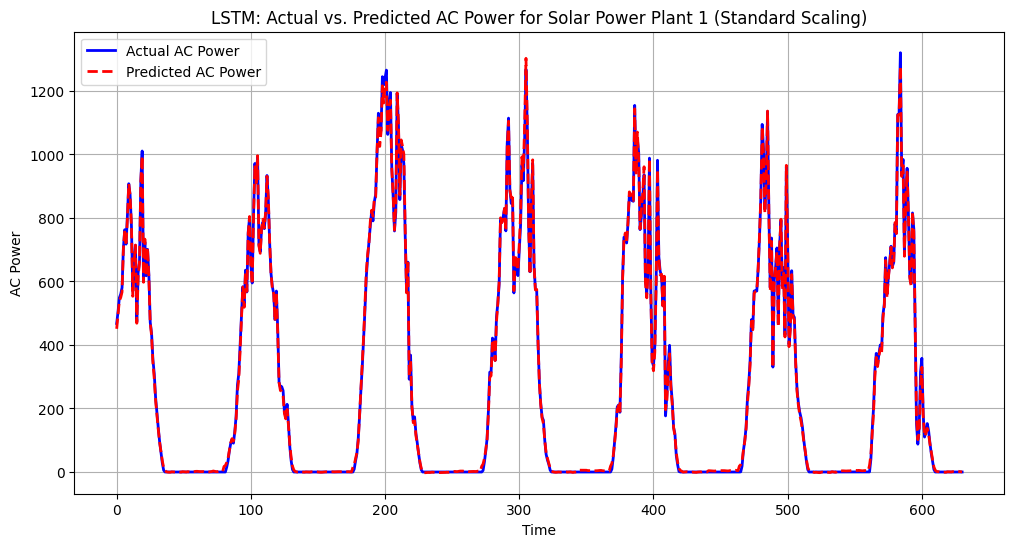

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train1_standard = X_train1_standard.reshape((X_train1_standard.shape[0], 1, X_train1_standard.shape[1]))
X_test1_standard = X_test1_standard.reshape((X_test1_standard.shape[0], 1, X_test1_standard.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train1_standard.shape[1], X_train1_standard.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train1_standard, y_train1_standard,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test1_standard, y_test1_standard),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test1_standard)
y_pred = scaler_y1_standard.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y1_standard.inverse_transform(y_test1_standard)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"LSTM Model Performance for Solar Power Plant 1 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("LSTM: Actual vs. Predicted AC Power for Solar Power Plant 1 (Standard Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# Standard Scaling for Plant 2
scaler_x2_standard = StandardScaler()
X_train2_standard = scaler_x2_standard.fit_transform(X_train2)
X_test2_standard = scaler_x2_standard.transform(X_test2)

scaler_y2_standard = StandardScaler()
y_train2_standard = scaler_y2_standard.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_standard = scaler_y2_standard.transform(y_test2.values.reshape(-1, 1))

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.7273 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0723 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0460 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0425 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0317 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0248 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0213 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0187 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 9/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 10/150
41/41

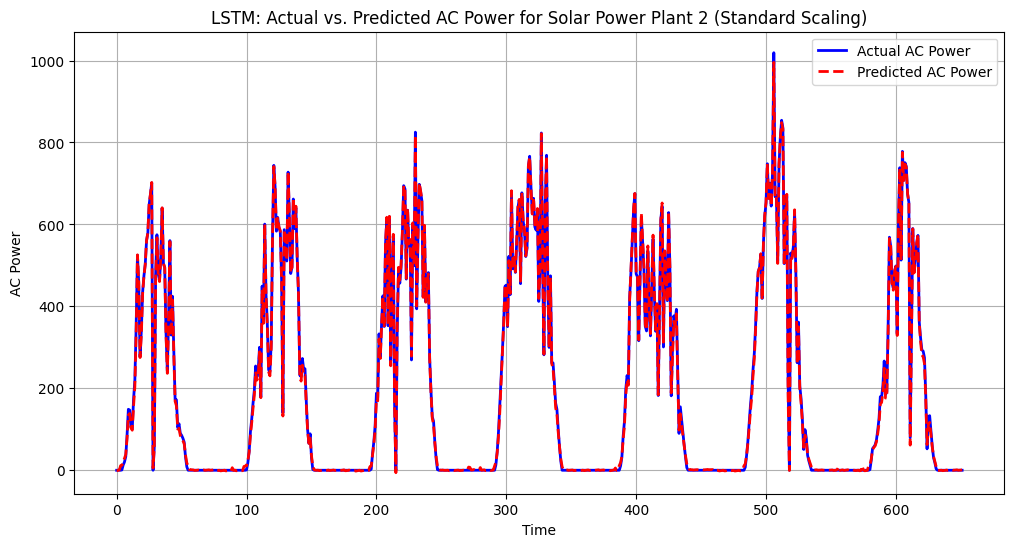

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train2_standard = X_train2_standard.reshape((X_train2_standard.shape[0], 1, X_train2_standard.shape[1]))
X_test2_standard = X_test2_standard.reshape((X_test2_standard.shape[0], 1, X_test2_standard.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train2_standard.shape[1], X_train2_standard.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train2_standard, y_train2_standard,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test2_standard, y_test2_standard),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test2_standard)
y_pred = scaler_y2_standard.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y2_standard.inverse_transform(y_test2_standard)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"LSTM Model Performance for Solar Power Plant 2 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("LSTM: Actual vs. Predicted AC Power for Solar Power Plant 2 (Standard Scaling)")
plt.grid(True)
plt.show()

MinMax Scaling:

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 1
scaler_x1_minmax = MinMaxScaler()
X_train1_minmax = scaler_x1_minmax.fit_transform(X_train1)
X_test1_minmax = scaler_x1_minmax.transform(X_test1)

scaler_y1_minmax = MinMaxScaler()
y_train1_minmax = scaler_y1_minmax.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_minmax = scaler_y1_minmax.transform(y_test1.values.reshape(-1, 1))

Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0884 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - val_loss: 7.8932e-04 - learning_rate: 0.0010
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 9.1414e-04 - learning_rate: 0.0010
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - val_loss: 4.7732e-04 - learning_rate: 0.0010
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 3.5877e-04 - learning_rate: 0.0010
Ep

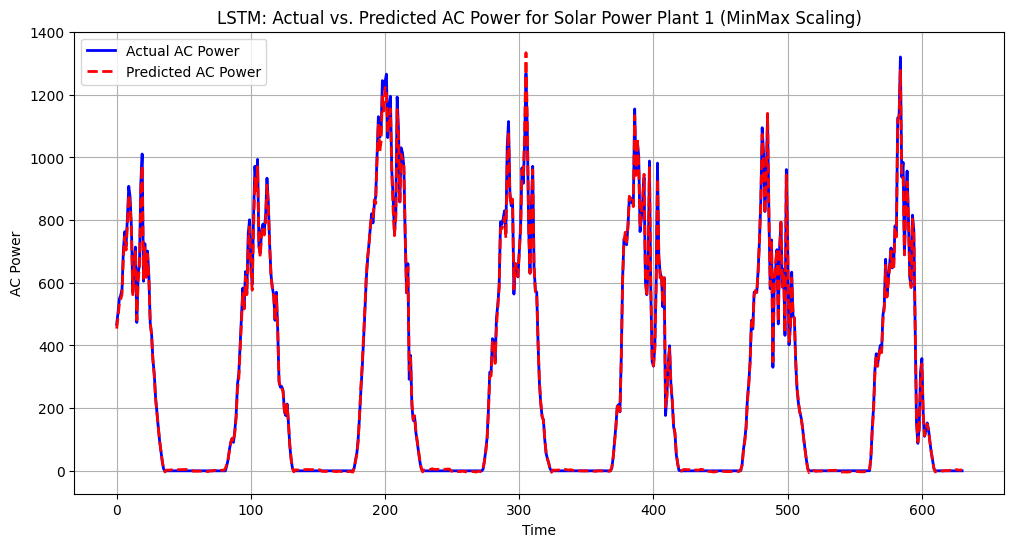

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train1_minmax = X_train1_minmax.reshape((X_train1_minmax.shape[0], 1, X_train1_minmax.shape[1]))
X_test1_minmax = X_test1_minmax.reshape((X_test1_minmax.shape[0], 1, X_test1_minmax.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train1_minmax.shape[1], X_train1_minmax.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train1_minmax, y_train1_minmax,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test1_minmax, y_test1_minmax),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test1_minmax)
y_pred = scaler_y1_minmax.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y1_minmax.inverse_transform(y_test1_minmax)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"LSTM Model Performance for Solar Power Plant 1 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("LSTM: Actual vs. Predicted AC Power for Solar Power Plant 1 (MinMax Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 2
scaler_x2_minmax = MinMaxScaler()
X_train2_minmax = scaler_x2_minmax.fit_transform(X_train2)
X_test2_minmax = scaler_x2_minmax.transform(X_test2)

scaler_y2_minmax = MinMaxScaler()
y_train2_minmax = scaler_y2_minmax.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_minmax = scaler_y2_minmax.transform(y_test2.values.reshape(-1, 1))

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0740 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0076 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 8.6453e-04 - learning_rate: 0.0010
Epoch 9/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 10/150
4

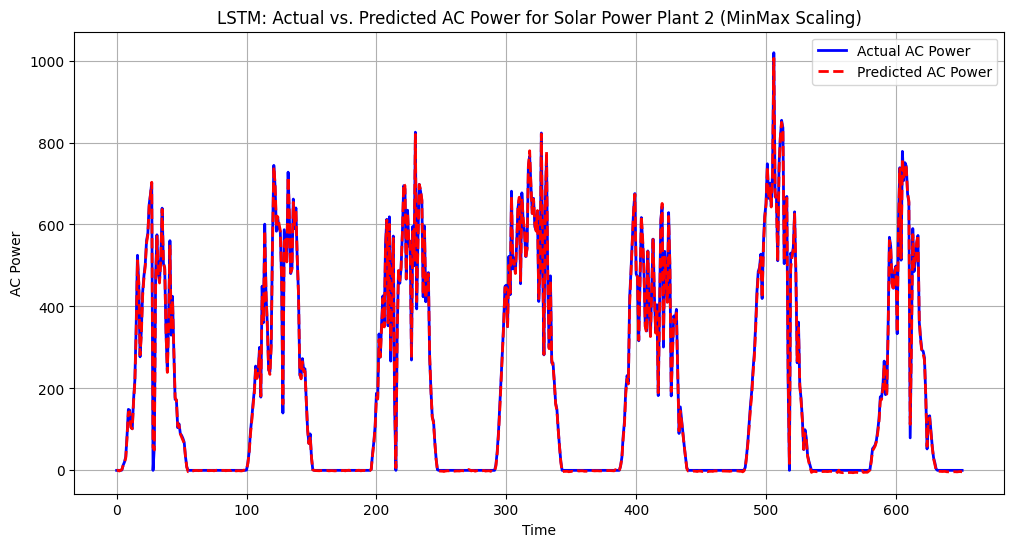

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train2_minmax = X_train2_minmax.reshape((X_train2_minmax.shape[0], 1, X_train2_minmax.shape[1]))
X_test2_minmax = X_test2_minmax.reshape((X_test2_minmax.shape[0], 1, X_test2_minmax.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train2_minmax.shape[1], X_train2_minmax.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train2_minmax, y_train2_minmax,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test2_minmax, y_test2_minmax),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test2_minmax)
y_pred = scaler_y2_minmax.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y2_minmax.inverse_transform(y_test2_minmax)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"LSTM Model Performance for Solar Power Plant 2 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("LSTM: Actual vs. Predicted AC Power for Solar Power Plant 2 (MinMax Scaling)")
plt.grid(True)
plt.show()

**Bidirectional Long Short-Term Memory (BiLSTM) Model:**

Standard Scaling:

In [ ]:
# Feature scaling

# Standard Scaling for Plant 1
scaler_x1_standard = StandardScaler()
X_train1_standard = scaler_x1_standard.fit_transform(X_train1)
X_test1_standard = scaler_x1_standard.transform(X_test1)

scaler_y1_standard = StandardScaler()
y_train1_standard = scaler_y1_standard.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_standard = scaler_y1_standard.transform(y_test1.values.reshape(-1, 1))

Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.3551 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0202 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0132 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0106 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0097 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0084 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0088 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0080 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0071 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 10/1

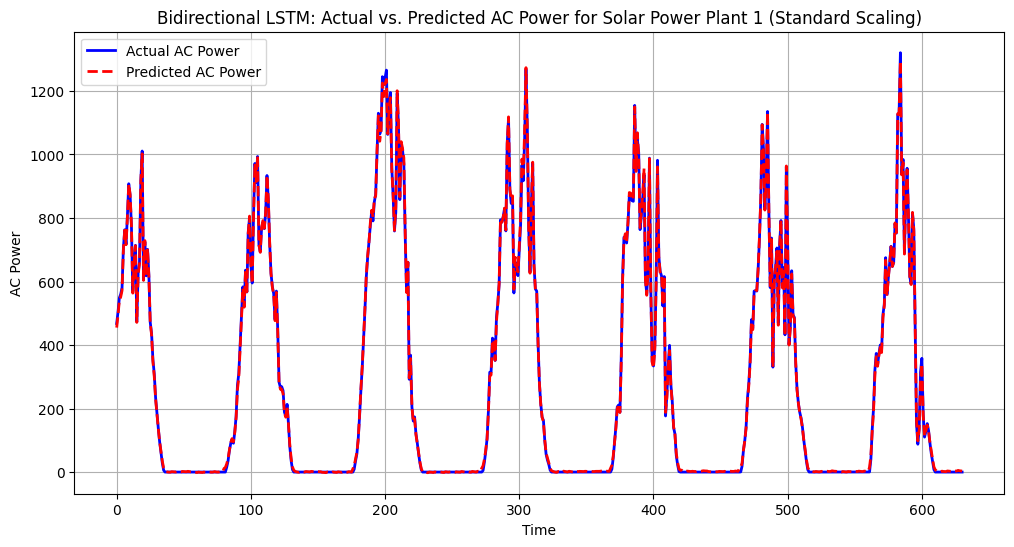

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train1_standard = X_train1_standard.reshape((X_train1_standard.shape[0], 1, X_train1_standard.shape[1]))
X_test1_standard = X_test1_standard.reshape((X_test1_standard.shape[0], 1, X_test1_standard.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(patience=15, min_delta=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train1_standard.shape[1], X_train1_standard.shape[2])),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train1_standard, y_train1_standard,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test1_standard, y_test1_standard),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test1_standard)
y_pred = scaler_y1_standard.inverse_transform(y_pred_scaled.reshape(-1, 1))  # Ensure correct shape
y_test_actual = scaler_y1_standard.inverse_transform(y_test1_standard)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Bidirectional LSTM Model Performance for Solar Power Plant 1 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("Bidirectional LSTM: Actual vs. Predicted AC Power for Solar Power Plant 1 (Standard Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# Standard Scaling for Plant 2
scaler_x2_standard = StandardScaler()
X_train2_standard = scaler_x2_standard.fit_transform(X_train2)
X_test2_standard = scaler_x2_standard.transform(X_test2)

scaler_y2_standard = StandardScaler()
y_train2_standard = scaler_y2_standard.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_standard = scaler_y2_standard.transform(y_test2.values.reshape(-1, 1))

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.3769 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0364 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0187 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0111 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0114 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0082 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0081 - val_loss: 8.7343e-04 - learning_rate: 0.0010
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 7.0675e-04 - learning_rate: 0.0010
Epoch 9/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0071 - val_loss: 8.2446e-04 - learning_rate: 0.001

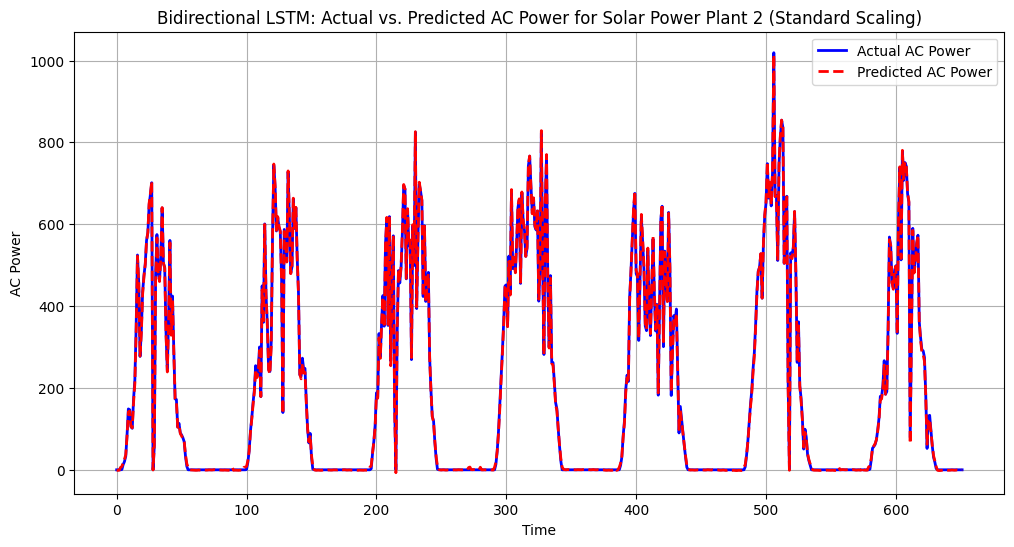

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train2_standard = X_train2_standard.reshape((X_train2_standard.shape[0], 1, X_train2_standard.shape[1]))
X_test2_standard = X_test2_standard.reshape((X_test2_standard.shape[0], 1, X_test2_standard.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train2_standard.shape[1], X_train2_standard.shape[2])),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train2_standard, y_train2_standard,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test2_standard, y_test2_standard),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test2_standard)
y_pred = scaler_y2_standard.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y2_standard.inverse_transform(y_test2_standard)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Bidirectional LSTM Model Performance for Solar Power Plant 2 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("Bidirectional LSTM: Actual vs. Predicted AC Power for Solar Power Plant 2 (Standard Scaling)")
plt.grid(True)
plt.show()

MinMax Scaling:

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 1
scaler_x1_minmax = MinMaxScaler()
X_train1_minmax = scaler_x1_minmax.fit_transform(X_train1)
X_test1_minmax = scaler_x1_minmax.transform(X_test1)

scaler_y1_minmax = MinMaxScaler()
y_train1_minmax = scaler_y1_minmax.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_minmax = scaler_y1_minmax.transform(y_test1.values.reshape(-1, 1))

Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0557 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0036 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0024 - val_loss: 7.0327e-04 - learning_rate: 0.0010
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018 - val_loss: 6.3614e-04 - learning_rate: 0.0010
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0016 - val_loss: 3.1127e-04 - learning_rate: 0.0010
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 2.7063e-04 - learning_rate: 0.0010
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - val_loss: 2.3704e-04 - learning_rate: 0.0010
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 2.2212e-04 - learning_rate: 0.0010
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 9.5886e-05 - lea

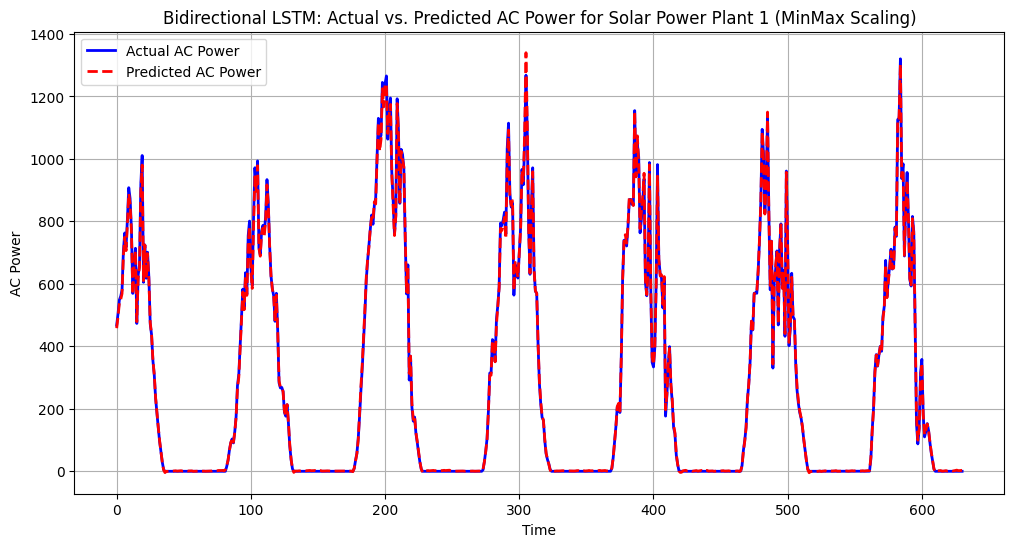

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train1_minmax = X_train1_minmax.reshape((X_train1_minmax.shape[0], 1, X_train1_minmax.shape[1]))
X_test1_minmax = X_test1_minmax.reshape((X_test1_minmax.shape[0], 1, X_test1_minmax.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train1_minmax.shape[1], X_train1_minmax.shape[2])),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train1_minmax, y_train1_minmax,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test1_minmax, y_test1_minmax),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test1_minmax)
y_pred = scaler_y1_minmax.inverse_transform(y_pred_scaled.reshape(-1, 1))  # Ensure correct shape
y_test_actual = scaler_y1_minmax.inverse_transform(y_test1_minmax)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Bidirectional LSTM Model Performance for Solar Power Plant 1 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("Bidirectional LSTM: Actual vs. Predicted AC Power for Solar Power Plant 1 (MinMax Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 2
scaler_x2_minmax = MinMaxScaler()
X_train2_minmax = scaler_x2_minmax.fit_transform(X_train2)
X_test2_minmax = scaler_x2_minmax.transform(X_test2)

scaler_y2_minmax = MinMaxScaler()
y_train2_minmax = scaler_y2_minmax.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_minmax = scaler_y2_minmax.transform(y_test2.values.reshape(-1, 1))

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0373 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0042 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0028 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0018 - val_loss: 4.7003e-04 - learning_rate: 0.0010
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0014 - val_loss: 3.9492e-04 - learning_rate: 0.0010
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0011 - val_loss: 5.0981e-04 - learning_rate: 0.0010
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.9007e-04 - val_loss: 1.7390e-04 - learning_rate: 0.0010
Epoch 9/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 9.6691e-04 - val_loss: 2.0936e-04 - lear

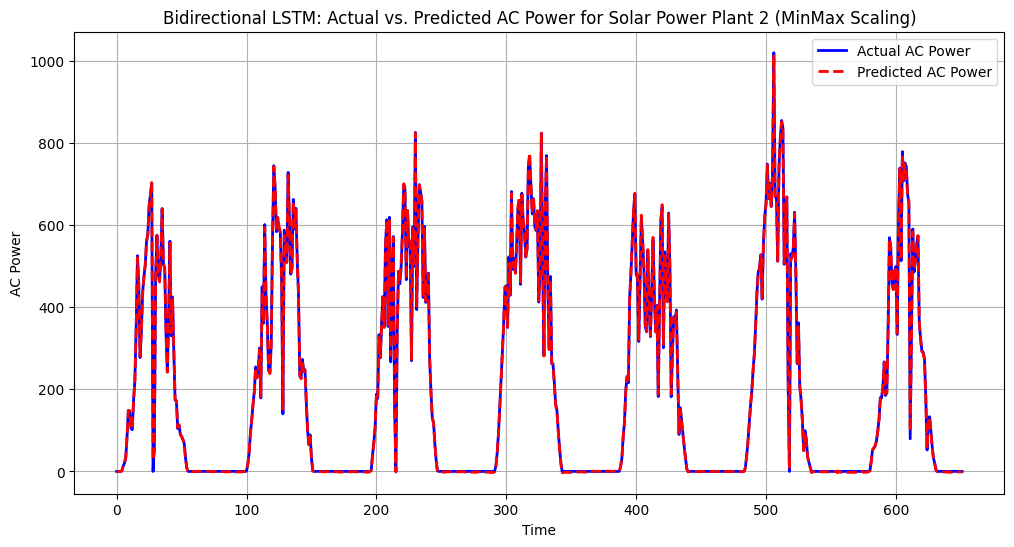

In [ ]:
# Reshape Data for LSTM (samples, timesteps, features)
X_train2_minmax = X_train2_minmax.reshape((X_train2_minmax.shape[0], 1, X_train2_minmax.shape[1]))
X_test2_minmax = X_test2_minmax.reshape((X_test2_minmax.shape[0], 1, X_test2_minmax.shape[1]))

# Define Fine-Tuned Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 150

# Define Early Stopping and Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

# Build Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train2_minmax.shape[1], X_train2_minmax.shape[2])),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(1, activation='linear')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Train Model
history = model.fit(
    X_train2_minmax, y_train2_minmax,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test2_minmax, y_test2_minmax),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make Predictions
y_pred_scaled = model.predict(X_test2_minmax)
y_pred = scaler_y2_minmax.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y2_minmax.inverse_transform(y_test2_minmax)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Bidirectional LSTM Model Performance for Solar Power Plant 2 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("Bidirectional LSTM: Actual vs. Predicted AC Power for Solar Power Plant 2 (MinMax Scaling)")
plt.grid(True)
plt.show()

**Adaptive Neuro-Fuzzy Inference System (ANFIS) Model:**

In [ ]:
# Feature scaling

# Standard Scaling for Plant 1
scaler_x1_standard = StandardScaler()
X_train1_standard = scaler_x1_standard.fit_transform(X_train1)
X_test1_standard = scaler_x1_standard.transform(X_test1)

scaler_y1_standard = StandardScaler()
y_train1_standard = scaler_y1_standard.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_standard = scaler_y1_standard.transform(y_test1.values.reshape(-1, 1))

# Standard Scaling for Plant 2
scaler_x2_standard = StandardScaler()
X_train2_standard = scaler_x2_standard.fit_transform(X_train2)
X_test2_standard = scaler_x2_standard.transform(X_test2)

scaler_y2_standard = StandardScaler()
y_train2_standard = scaler_y2_standard.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_standard = scaler_y2_standard.transform(y_test2.values.reshape(-1, 1))

# MinMax Scaling for Plant 1
scaler_x1_minmax = MinMaxScaler()
X_train1_minmax = scaler_x1_minmax.fit_transform(X_train1)
X_test1_minmax = scaler_x1_minmax.transform(X_test1)

scaler_y1_minmax = MinMaxScaler()
y_train1_minmax = scaler_y1_minmax.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_minmax = scaler_y1_minmax.transform(y_test1.values.reshape(-1, 1))

# MinMax Scaling for Plant 2
scaler_x2_minmax = MinMaxScaler()
X_train2_minmax = scaler_x2_minmax.fit_transform(X_train2)
X_test2_minmax = scaler_x2_minmax.transform(X_test2)

scaler_y2_minmax = MinMaxScaler()
y_train2_minmax = scaler_y2_minmax.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_minmax = scaler_y2_minmax.transform(y_test2.values.reshape(-1, 1))

Standard Scaling:

Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8854 - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.5059 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3105 - val_loss: 0.1620 - learning_rate: 0.0010
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2094 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1576 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1258 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0926 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0727 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 9/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0643 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 10/150
79/

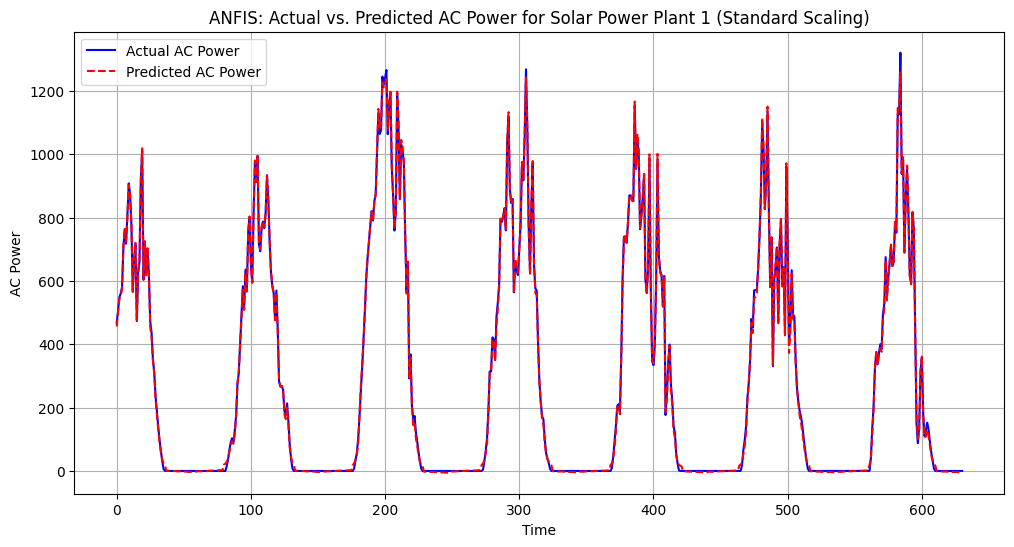

In [ ]:
# Ensure Standard Scaling
X_train = X_train1_standard
X_test = X_test1_standard
y_train = y_train1_standard.ravel()
y_test = y_test1_standard.ravel()

# Step 1: Define Gaussian Membership Function Layer
class GaussianMF(Layer):
    def __init__(self, num_mfs, **kwargs):
        super(GaussianMF, self).__init__(**kwargs)
        self.num_mfs = num_mfs

    def build(self, input_shape):
        self.centers = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                       initializer='random_normal',
                                       trainable=True)
        self.sigmas = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                      initializer='ones',
                                      trainable=True)

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        return tf.exp(-((expanded_inputs - self.centers) ** 2) / (2 * self.sigmas ** 2))

# Step 2: Define Fuzzy Rule Activation using Lambda Layer
def fuzzy_rules_layer(inputs):
    return tf.reduce_prod(inputs, axis=1)

# Step 3: Define the ANFIS Model with Lambda Layer Fix
def build_anfis_model(input_dim, num_rules=15):
    inputs = Input(shape=(input_dim,))
    mf_layer = GaussianMF(num_mfs=num_rules)(inputs)
    rule_layer = Lambda(fuzzy_rules_layer)(mf_layer)
    norm_layer = Lambda(lambda x: x / tf.reduce_sum(x, axis=1, keepdims=True))(rule_layer)
    output_layer = Dense(1, activation='linear')(norm_layer)

    model = keras.Model(inputs=inputs, outputs=output_layer)
    return model

# Step 4: Training and Evaluation
def train_anfis(X_train, y_train, X_test, y_test, num_rules=15, epochs=150, batch_size=32, learning_rate=0.001):
    input_dim = X_train.shape[1]
    model = build_anfis_model(input_dim, num_rules)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, reduce_lr],
                        verbose=1)

    # Step 5: Evaluate Model
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y1_standard.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y1_standard.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"ANFIS Model Performance for Solar Power Plant 1 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual AC Power", color='blue')
    plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("ANFIS: Actual vs. Predicted AC Power for Solar Power Plant 1 (Standard Scaling)")
    plt.grid(True)
    plt.show()

    return model

# Step 6: Train and Evaluate ANFIS
anfis_model = train_anfis(X_train1_standard, y_train1_standard, X_test1_standard, y_test1_standard)

Epoch 1/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8391 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 2/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4372 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 3/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2551 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 4/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1561 - val_loss: 0.0554 - learning_rate: 0.0010
Epoch 5/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1057 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 6/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0703 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 7/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0631 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 8/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 9/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0521 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 10/150
82/82 

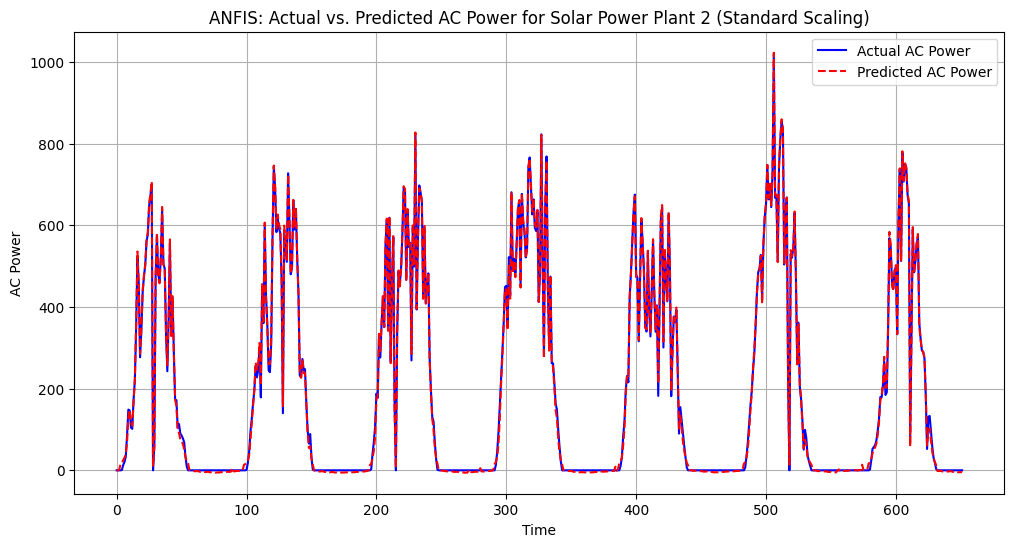

In [ ]:
# Ensure Standard Scaling
X_train = X_train2_standard
X_test = X_test2_standard
y_train = y_train2_standard.ravel()
y_test = y_test2_standard.ravel()

# Step 1: Define Gaussian Membership Function Layer
class GaussianMF(Layer):
    def __init__(self, num_mfs, **kwargs):
        super(GaussianMF, self).__init__(**kwargs)
        self.num_mfs = num_mfs

    def build(self, input_shape):
        self.centers = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                       initializer='random_normal',
                                       trainable=True)
        self.sigmas = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                      initializer='ones',
                                      trainable=True)

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        return tf.exp(-((expanded_inputs - self.centers) ** 2) / (2 * self.sigmas ** 2))

# Step 2: Define Fuzzy Rule Activation using Lambda Layer
def fuzzy_rules_layer(inputs):
    return tf.reduce_prod(inputs, axis=1)

# Step 3: Define the ANFIS Model with Lambda Layer Fix
def build_anfis_model(input_dim, num_rules=15):
    inputs = Input(shape=(input_dim,))
    mf_layer = GaussianMF(num_mfs=num_rules)(inputs)
    rule_layer = Lambda(fuzzy_rules_layer)(mf_layer)
    norm_layer = Lambda(lambda x: x / tf.reduce_sum(x, axis=1, keepdims=True))(rule_layer)
    output_layer = Dense(1, activation='linear')(norm_layer)

    model = keras.Model(inputs=inputs, outputs=output_layer)
    return model

# Step 4: Training and Evaluation
def train_anfis(X_train, y_train, X_test, y_test, num_rules=15, epochs=150, batch_size=32, learning_rate=0.001):
    input_dim = X_train.shape[1]
    model = build_anfis_model(input_dim, num_rules)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, reduce_lr],
                        verbose=1)

    # Step 5: Evaluate Model
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y2_standard.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y2_standard.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"ANFIS Model Performance for Solar Power Plant 2 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual AC Power", color='blue')
    plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("ANFIS: Actual vs. Predicted AC Power for Solar Power Plant 2 (Standard Scaling)")
    plt.grid(True)
    plt.show()

    return model

# Step 6: Train and Evaluate ANFIS
anfis_model = train_anfis(X_train2_standard, y_train2_standard, X_test2_standard, y_test2_standard)

MinMax Scaling:

Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1129 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 9/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 10/150
79/79 

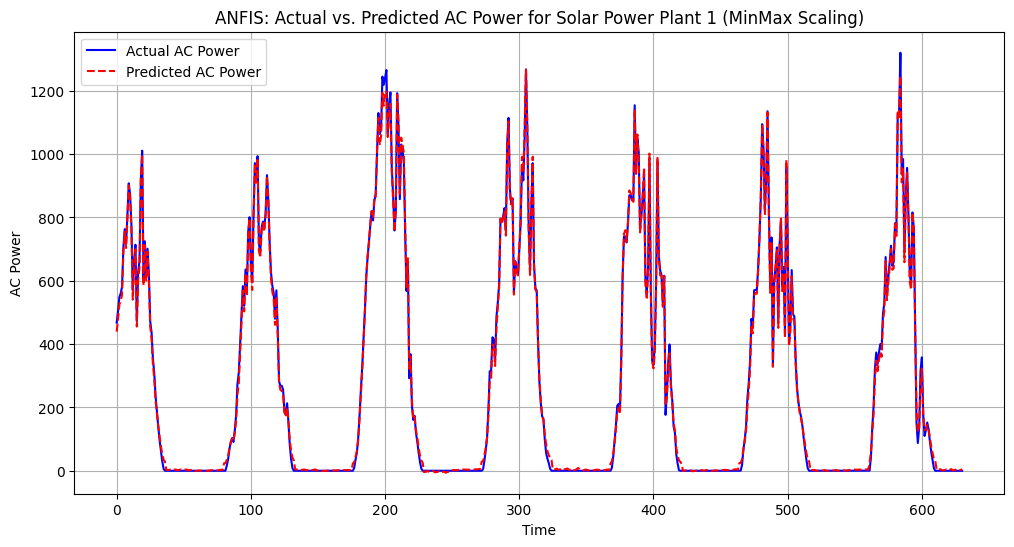

In [ ]:
# Ensure MinMax Scaling
X_train = X_train1_minmax
X_test = X_test1_minmax
y_train = y_train1_minmax.ravel()
y_test = y_test1_minmax.ravel()

# Step 1: Define Gaussian Membership Function Layer
class GaussianMF(Layer):
    def __init__(self, num_mfs, **kwargs):
        super(GaussianMF, self).__init__(**kwargs)
        self.num_mfs = num_mfs

    def build(self, input_shape):
        self.centers = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                       initializer='random_normal',
                                       trainable=True)
        self.sigmas = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                      initializer='ones',
                                      trainable=True)

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        return tf.exp(-((expanded_inputs - self.centers) ** 2) / (2 * self.sigmas ** 2))

# Step 2: Define Fuzzy Rule Activation using Lambda Layer
def fuzzy_rules_layer(inputs):
    return tf.reduce_prod(inputs, axis=1)

# Step 3: Define the ANFIS Model with Lambda Layer Fix
def build_anfis_model(input_dim, num_rules=15):
    inputs = Input(shape=(input_dim,))
    mf_layer = GaussianMF(num_mfs=num_rules)(inputs)
    rule_layer = Lambda(fuzzy_rules_layer)(mf_layer)
    norm_layer = Lambda(lambda x: x / tf.reduce_sum(x, axis=1, keepdims=True))(rule_layer)
    output_layer = Dense(1, activation='linear')(norm_layer)

    model = keras.Model(inputs=inputs, outputs=output_layer)
    return model

# Step 4: Training and Evaluation
def train_anfis(X_train, y_train, X_test, y_test, num_rules=15, epochs=150, batch_size=32, learning_rate=0.001):
    input_dim = X_train.shape[1]
    model = build_anfis_model(input_dim, num_rules)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, reduce_lr],
                        verbose=1)

    # Step 5: Evaluate Model
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y1_minmax.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y1_minmax.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"ANFIS Model Performance for Solar Power Plant 1 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual AC Power", color='blue')
    plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("ANFIS: Actual vs. Predicted AC Power for Solar Power Plant 1 (MinMax Scaling)")
    plt.grid(True)
    plt.show()

    return model

# Step 6: Train and Evaluate ANFIS
anfis_model = train_anfis(X_train1_minmax, y_train1_minmax, X_test1_minmax, y_test1_minmax)

Epoch 1/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0778 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 2/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 3/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 4/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 5/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 6/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 7/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 8/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 10/150
82/82 

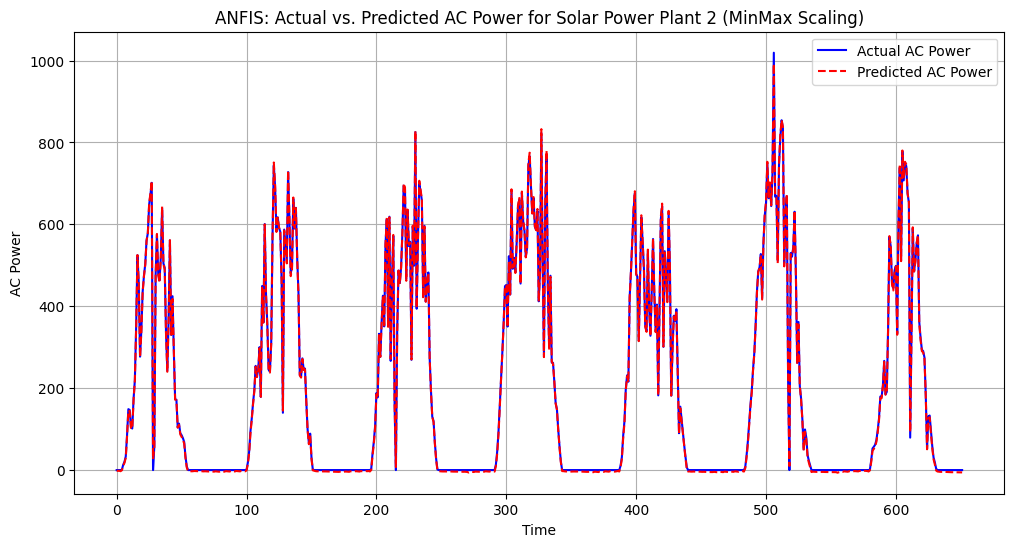

In [ ]:
# Ensure MinMax Scaling
X_train = X_train2_minmax
X_test = X_test2_minmax
y_train = y_train2_minmax.ravel()
y_test = y_test2_minmax.ravel()

# Step 1: Define Gaussian Membership Function Layer
class GaussianMF(Layer):
    def __init__(self, num_mfs, **kwargs):
        super(GaussianMF, self).__init__(**kwargs)
        self.num_mfs = num_mfs

    def build(self, input_shape):
        self.centers = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                       initializer='random_normal',
                                       trainable=True)
        self.sigmas = self.add_weight(shape=(input_shape[-1], self.num_mfs),
                                      initializer='ones',
                                      trainable=True)

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        return tf.exp(-((expanded_inputs - self.centers) ** 2) / (2 * self.sigmas ** 2))

# Step 2: Define Fuzzy Rule Activation using Lambda Layer
def fuzzy_rules_layer(inputs):
    return tf.reduce_prod(inputs, axis=1)

# Step 3: Define the ANFIS Model with Lambda Layer Fix
def build_anfis_model(input_dim, num_rules=15):
    inputs = Input(shape=(input_dim,))
    mf_layer = GaussianMF(num_mfs=num_rules)(inputs)
    rule_layer = Lambda(fuzzy_rules_layer)(mf_layer)
    norm_layer = Lambda(lambda x: x / tf.reduce_sum(x, axis=1, keepdims=True))(rule_layer)
    output_layer = Dense(1, activation='linear')(norm_layer)

    model = keras.Model(inputs=inputs, outputs=output_layer)
    return model

# Step 4: Training and Evaluation
def train_anfis(X_train, y_train, X_test, y_test, num_rules=15, epochs=150, batch_size=32, learning_rate=0.001):
    input_dim = X_train.shape[1]
    model = build_anfis_model(input_dim, num_rules)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-5)

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, reduce_lr],
                        verbose=1)

    # Step 5: Evaluate Model
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y2_minmax.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y2_minmax.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"ANFIS Model Performance for Solar Power Plant 2 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual AC Power", color='blue')
    plt.plot(y_pred, label="Predicted AC Power", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("ANFIS: Actual vs. Predicted AC Power for Solar Power Plant 2 (MinMax Scaling)")
    plt.grid(True)
    plt.show()

    return model

# Step 6: Train and Evaluate ANFIS
anfis_model = train_anfis(X_train2_minmax, y_train2_minmax, X_test2_minmax, y_test2_minmax)

**XGBoost Model:**

Standard Scaling:

XGBoost Model Performance for Solar Power Plant 1 (Standard Scaling):
RMSE: 5.28, MAE: 2.90, R²: 1.00


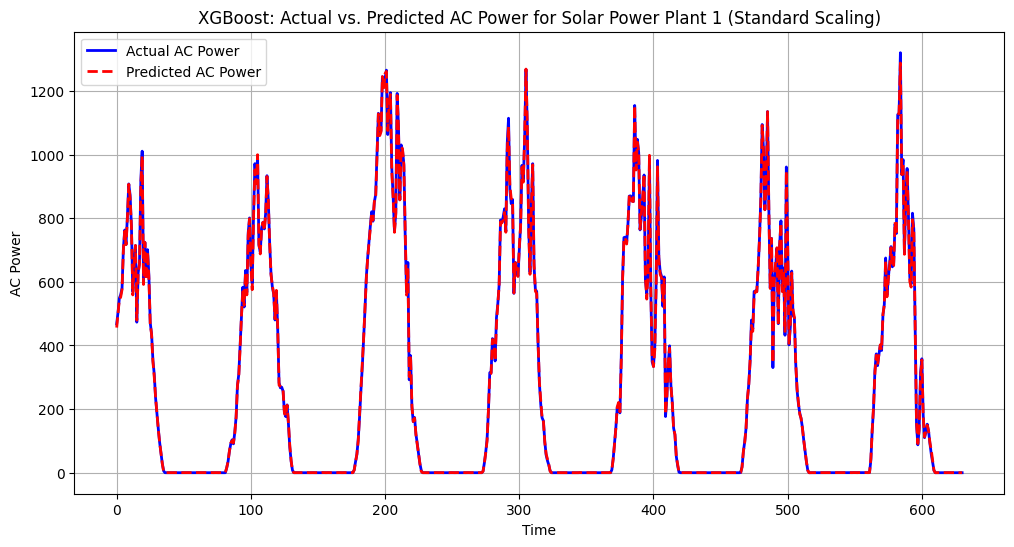

In [ ]:
# Define a function to evaluate the model
def evaluate_model(y_true, y_pred, scaler_y):
    # Inverse transform predictions to get actual values
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return rmse, mae, r2, y_true, y_pred

# Function to train XGBoost without early stopping
def train_xgboost(X_train, X_test, y_train, y_test, scaler_y):
    # Define model with default parameters and eval_metric inside initialization
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train.ravel(), verbose=True)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse, mae, r2, y_true, y_pred = evaluate_model(y_test, y_pred, scaler_y)
    print(f"XGBoost Model Performance for Solar Power Plant 1 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual AC Power", color="blue", linewidth=2)
    plt.plot(y_pred, label="Predicted AC Power", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("XGBoost: Actual vs. Predicted AC Power for Solar Power Plant 1 (Standard Scaling)")
    plt.grid(True)
    plt.show()

    return model, (rmse, mae, r2)

# Train and evaluate on Standard Scaled data
model_standard, metrics_standard = train_xgboost(
    X_train1_standard, X_test1_standard, y_train1_standard, y_test1_standard, scalers["scaler_y1_standard"]
)

XGBoost Model Performance for Solar Power Plant 2 (Standard Scaling):
RMSE: 8.19, MAE: 3.84, R²: 1.00


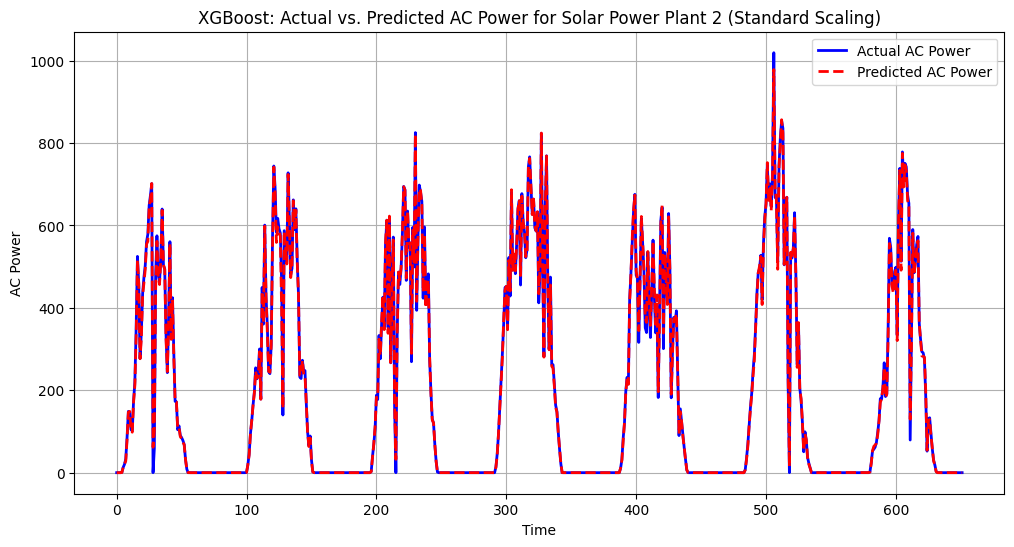

In [ ]:
# Define a function to evaluate the model
def evaluate_model(y_true, y_pred, scaler_y):
    # Inverse transform predictions to get actual values
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return rmse, mae, r2, y_true, y_pred

# Function to train XGBoost without early stopping
def train_xgboost(X_train, X_test, y_train, y_test, scaler_y):
    # Define model with default parameters and eval_metric inside initialization
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train.ravel(), verbose=True)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse, mae, r2, y_true, y_pred = evaluate_model(y_test, y_pred, scaler_y)
    print(f"XGBoost Model Performance for Solar Power Plant 2 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual AC Power", color="blue", linewidth=2)
    plt.plot(y_pred, label="Predicted AC Power", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("XGBoost: Actual vs. Predicted AC Power for Solar Power Plant 2 (Standard Scaling)")
    plt.grid(True)
    plt.show()

    return model, (rmse, mae, r2)

# Train and evaluate on Standard Scaled data
model_standard, metrics_standard = train_xgboost(
    X_train2_standard, X_test2_standard, y_train2_standard, y_test2_standard, scalers["scaler_y2_standard"]
)

MinMax Scaling:

XGBoost Model Performance for Solar Power Plant 1 (MinMax Scaling):
RMSE: 5.44, MAE: 3.10, R²: 1.00


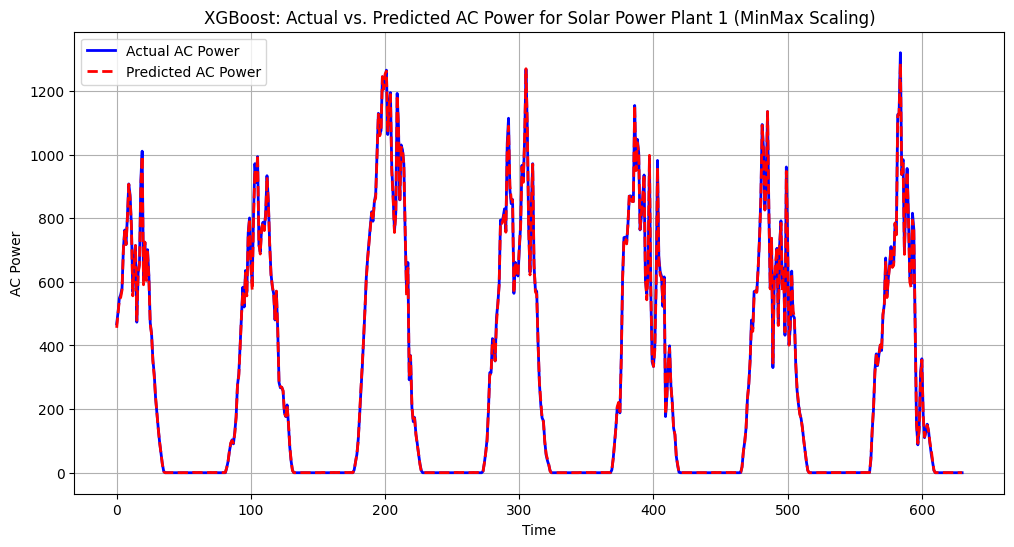

In [ ]:
# Define a function to evaluate the model
def evaluate_model(y_true, y_pred, scaler_y):
    # Inverse transform predictions to get actual values
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return rmse, mae, r2, y_true, y_pred

# Function to train XGBoost without early stopping
def train_xgboost(X_train, X_test, y_train, y_test, scaler_y):
    # Define model with default parameters and eval_metric inside initialization
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train.ravel(), verbose=True)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse, mae, r2, y_true, y_pred = evaluate_model(y_test, y_pred, scaler_y)
    print(f"XGBoost Model Performance for Solar Power Plant 1 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual AC Power", color="blue", linewidth=2)
    plt.plot(y_pred, label="Predicted AC Power", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("XGBoost: Actual vs. Predicted AC Power for Solar Power Plant 1 (MinMax Scaling)")
    plt.grid(True)
    plt.show()

    return model, (rmse, mae, r2)

# Train and evaluate on MinMax Scaled data
model_minmax, metrics_minmax = train_xgboost(
    X_train1_minmax, X_test1_minmax, y_train1_minmax, y_test1_minmax, scalers["scaler_y1_minmax"]
)

XGBoost Model Performance for Solar Power Plant 2 (MinMax Scaling):
RMSE: 8.25, MAE: 3.89, R²: 1.00


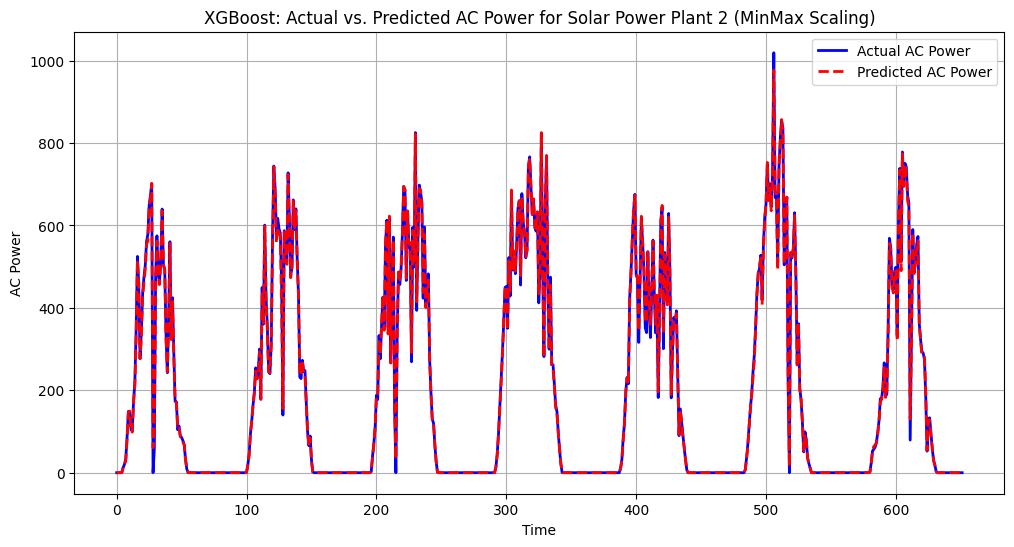

In [ ]:
# Define a function to evaluate the model
def evaluate_model(y_true, y_pred, scaler_y):
    # Inverse transform predictions to get actual values
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return rmse, mae, r2, y_true, y_pred

# Function to train XGBoost without early stopping
def train_xgboost(X_train, X_test, y_train, y_test, scaler_y):
    # Define model with default parameters and eval_metric inside initialization
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train.ravel(), verbose=True)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse, mae, r2, y_true, y_pred = evaluate_model(y_test, y_pred, scaler_y)
    print(f"XGBoost Model Performance for Solar Power Plant 2 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual AC Power", color="blue", linewidth=2)
    plt.plot(y_pred, label="Predicted AC Power", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("AC Power")
    plt.legend()
    plt.title("XGBoost: Actual vs. Predicted AC Power for Solar Power Plant 2 (MinMax Scaling)")
    plt.grid(True)
    plt.show()

    return model, (rmse, mae, r2)

# Train and evaluate on MinMax Scaled data
model_minmax, metrics_minmax = train_xgboost(
    X_train2_minmax, X_test2_minmax, y_train2_minmax, y_test2_minmax, scalers["scaler_y2_minmax"]
)

**SVM-ANN (Support Vector Machine - Artificial Neural Network) Model:**

Standard Scaling:

In [ ]:
# Feature scaling

# Standard Scaling for Plant 1
scaler_x1_standard = StandardScaler()
X_train1_standard = scaler_x1_standard.fit_transform(X_train1)
X_test1_standard = scaler_x1_standard.transform(X_test1)

scaler_y1_standard = StandardScaler()
y_train1_standard = scaler_y1_standard.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_standard = scaler_y1_standard.transform(y_test1.values.reshape(-1, 1))

Epoch [1/150], Loss: 1.1271, Val Loss: 0.8001
Epoch [2/150], Loss: 0.9514, Val Loss: 0.6713
Epoch [3/150], Loss: 0.7956, Val Loss: 0.5589
Epoch [4/150], Loss: 0.6603, Val Loss: 0.4587
Epoch [5/150], Loss: 0.5392, Val Loss: 0.3714
Epoch [6/150], Loss: 0.4334, Val Loss: 0.2959
Epoch [7/150], Loss: 0.3434, Val Loss: 0.2304
Epoch [8/150], Loss: 0.2656, Val Loss: 0.1753
Epoch [9/150], Loss: 0.1997, Val Loss: 0.1295
Epoch [10/150], Loss: 0.1458, Val Loss: 0.0923
Epoch [11/150], Loss: 0.1023, Val Loss: 0.0629
Epoch [12/150], Loss: 0.0677, Val Loss: 0.0404
Epoch [13/150], Loss: 0.0419, Val Loss: 0.0238
Epoch [14/150], Loss: 0.0233, Val Loss: 0.0126
Epoch [15/150], Loss: 0.0111, Val Loss: 0.0064
Epoch [16/150], Loss: 0.0050, Val Loss: 0.0044
Epoch [17/150], Loss: 0.0039, Val Loss: 0.0057
Epoch [18/150], Loss: 0.0067, Val Loss: 0.0092
Epoch [19/150], Loss: 0.0120, Val Loss: 0.0137
Epoch [20/150], Loss: 0.0184, Val Loss: 0.0183
Epoch [21/150], Loss: 0.0247, Val Loss: 0.0221
Epoch [22/150], Loss: 

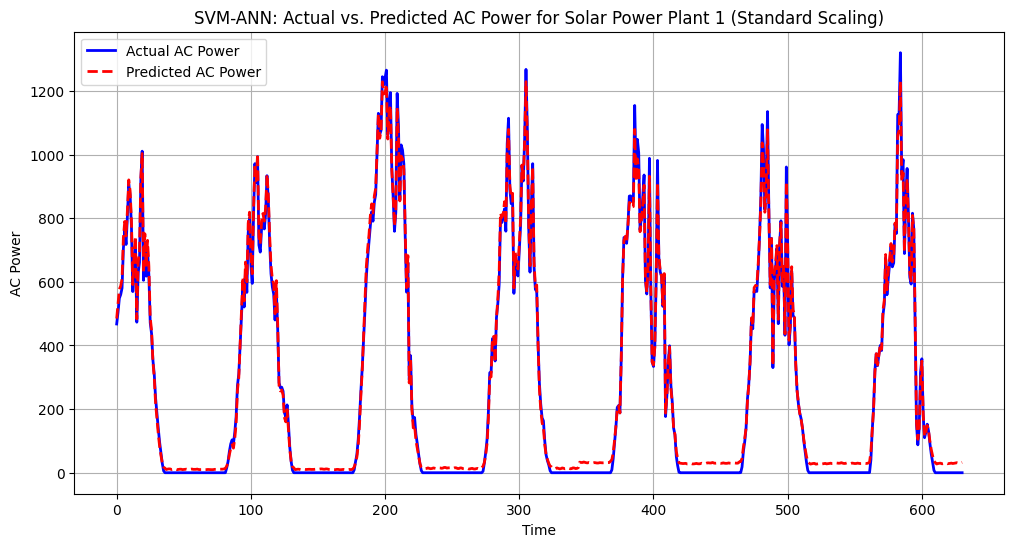

In [ ]:
# Step 1: Train an SVM Model
svm_model = SVR(kernel='rbf', C=50, gamma='scale', epsilon=0.005)
svm_model.fit(X_train1_standard, y_train1_standard.ravel())

# Step 2: Get Decision Function Outputs (New Features for ANN)
X_train_svm = svm_model.predict(X_train1_standard).reshape(-1, 1)
X_test_svm = svm_model.predict(X_test1_standard).reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train1_standard, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_svm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test1_standard, dtype=torch.float32)

# Define Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001):
        """
        Stops training if validation loss doesn't improve for 'patience' epochs.
        :param patience: Number of epochs to wait before stopping
        :param min_delta: Minimum change to qualify as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Define ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize Model
input_dim = X_train_tensor.shape[1]
model = ANNModel(input_dim)

# Define Loss Function & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Early stopping instance
early_stopping = EarlyStopping(patience=15, min_delta=0.0001)

# Training Loop with Early Stopping
EPOCHS = 150
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward Pass
    loss.backward()
    optimizer.step()

    # Evaluate on Validation Set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # Check early stopping condition
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Training stopped.")
        break

# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert predictions back to original scale
y_pred_test = scalers["scaler_y1_standard"].inverse_transform(y_pred_test.cpu().numpy())
y_test_actual = scalers["scaler_y1_standard"].inverse_transform(y_test_tensor.cpu().numpy())

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
mae = mean_absolute_error(y_test_actual, y_pred_test)
r2 = r2_score(y_test_actual, y_pred_test)

print(f"SVM-ANN Model Performance for Solar Power Plant 1 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred_test, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVM-ANN: Actual vs. Predicted AC Power for Solar Power Plant 1 (Standard Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# Standard Scaling for Plant 2
scaler_x2_standard = StandardScaler()
X_train2_standard = scaler_x2_standard.fit_transform(X_train2)
X_test2_standard = scaler_x2_standard.transform(X_test2)

scaler_y2_standard = StandardScaler()
y_train2_standard = scaler_y2_standard.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_standard = scaler_y2_standard.transform(y_test2.values.reshape(-1, 1))

Epoch [1/150], Loss: 1.1766, Val Loss: 0.6338
Epoch [2/150], Loss: 1.0124, Val Loss: 0.5380
Epoch [3/150], Loss: 0.8662, Val Loss: 0.4514
Epoch [4/150], Loss: 0.7345, Val Loss: 0.3757
Epoch [5/150], Loss: 0.6180, Val Loss: 0.3091
Epoch [6/150], Loss: 0.5142, Val Loss: 0.2511
Epoch [7/150], Loss: 0.4234, Val Loss: 0.2004
Epoch [8/150], Loss: 0.3437, Val Loss: 0.1564
Epoch [9/150], Loss: 0.2747, Val Loss: 0.1186
Epoch [10/150], Loss: 0.2146, Val Loss: 0.0868
Epoch [11/150], Loss: 0.1627, Val Loss: 0.0606
Epoch [12/150], Loss: 0.1187, Val Loss: 0.0394
Epoch [13/150], Loss: 0.0824, Val Loss: 0.0238
Epoch [14/150], Loss: 0.0543, Val Loss: 0.0129
Epoch [15/150], Loss: 0.0331, Val Loss: 0.0066
Epoch [16/150], Loss: 0.0187, Val Loss: 0.0042
Epoch [17/150], Loss: 0.0105, Val Loss: 0.0051
Epoch [18/150], Loss: 0.0076, Val Loss: 0.0082
Epoch [19/150], Loss: 0.0085, Val Loss: 0.0125
Epoch [20/150], Loss: 0.0119, Val Loss: 0.0172
Epoch [21/150], Loss: 0.0168, Val Loss: 0.0215
Epoch [22/150], Loss: 

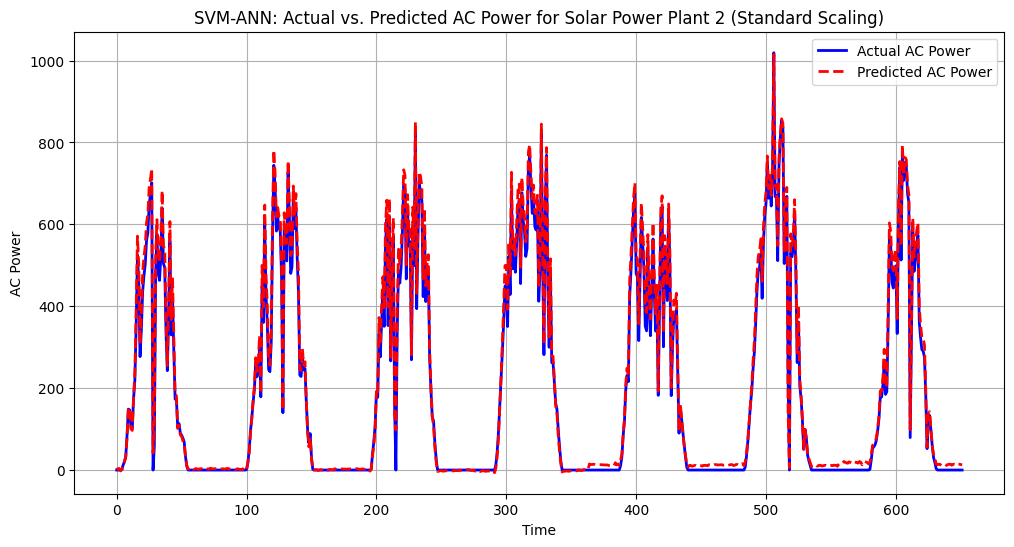

In [ ]:
# Step 1: Train an SVM Model
svm_model = SVR(kernel='rbf', C=50, gamma='scale', epsilon=0.005)
svm_model.fit(X_train2_standard, y_train2_standard.ravel())

# Step 2: Get Decision Function Outputs (New Features for ANN)
X_train_svm = svm_model.predict(X_train2_standard).reshape(-1, 1)
X_test_svm = svm_model.predict(X_test2_standard).reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train2_standard, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_svm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test2_standard, dtype=torch.float32)

# Define Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001):
        """
        Stops training if validation loss doesn't improve for 'patience' epochs.
        :param patience: Number of epochs to wait before stopping
        :param min_delta: Minimum change to qualify as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Define ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize Model
input_dim = X_train_tensor.shape[1]
model = ANNModel(input_dim)

# Define Loss Function & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Early stopping instance
early_stopping = EarlyStopping(patience=15, min_delta=0.0001)

# Training Loop with Early Stopping
EPOCHS = 150
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward Pass
    loss.backward()
    optimizer.step()

    # Evaluate on Validation Set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # Check early stopping condition
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Training stopped.")
        break

# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert predictions back to original scale
y_pred_test = scalers["scaler_y2_standard"].inverse_transform(y_pred_test.cpu().numpy())
y_test_actual = scalers["scaler_y2_standard"].inverse_transform(y_test_tensor.cpu().numpy())

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
mae = mean_absolute_error(y_test_actual, y_pred_test)
r2 = r2_score(y_test_actual, y_pred_test)

print(f"SVM-ANN Model Performance for Power Plant 2 (Standard Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred_test, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVM-ANN: Actual vs. Predicted AC Power for Solar Power Plant 2 (Standard Scaling)")
plt.grid(True)
plt.show()

MinMax Scaling:

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 1
scaler_x1_minmax = MinMaxScaler()
X_train1_minmax = scaler_x1_minmax.fit_transform(X_train1)
X_test1_minmax = scaler_x1_minmax.transform(X_test1)

scaler_y1_minmax = MinMaxScaler()
y_train1_minmax = scaler_y1_minmax.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_minmax = scaler_y1_minmax.transform(y_test1.values.reshape(-1, 1))

Epoch [10/100], Loss: 0.0327
Epoch [20/100], Loss: 0.0022
Epoch [30/100], Loss: 0.0022
Epoch [40/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
SVM-ANN Model Performance for Power Plant 1 (MinMax Scaling):
RMSE: 8.19, MAE: 6.60, R²: 1.00


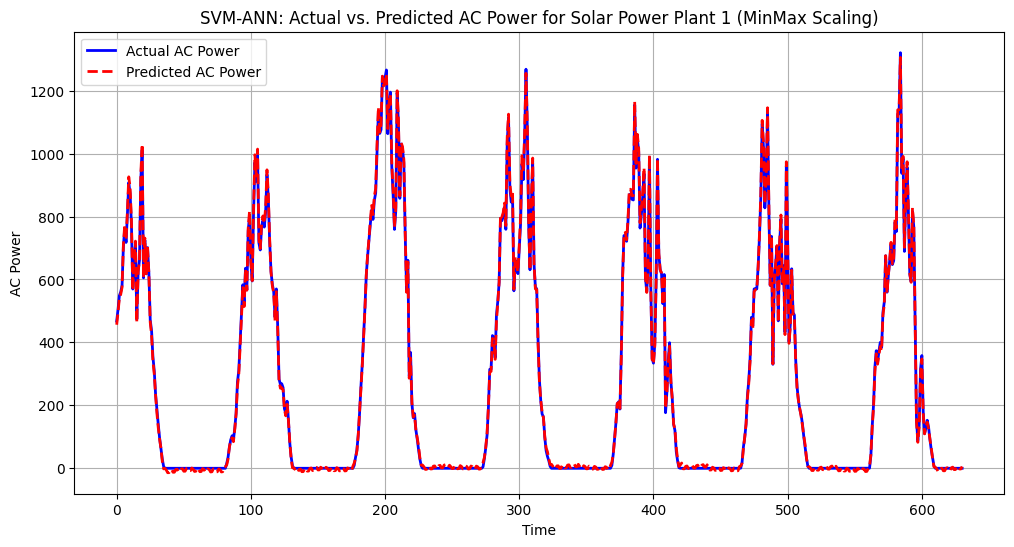

In [ ]:
# Step 1: Train an SVM Model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_model.fit(X_train1_minmax, y_train1_minmax.ravel())

# Step 2: Get Decision Function Outputs (New Features for ANN)
X_train_svm = svm_model.predict(X_train1_minmax).reshape(-1, 1)
X_test_svm = svm_model.predict(X_test1_minmax).reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train1_minmax, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_svm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test1_minmax, dtype=torch.float32)

# Step 3: Define ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize Model
input_dim = X_train_tensor.shape[1]
model = ANNModel(input_dim)

# Define Loss Function & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert data to device
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Step 4: Train ANN Model
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward Pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

# Step 5: Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert predictions back to original scale
y_pred_test = scalers["scaler_y1_minmax"].inverse_transform(y_pred_test.cpu().numpy())
y_test_actual = scalers["scaler_y1_minmax"].inverse_transform(y_test_tensor.cpu().numpy())

# Step 6: Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
mae = mean_absolute_error(y_test_actual, y_pred_test)
r2 = r2_score(y_test_actual, y_pred_test)

print(f"SVM-ANN Model Performance for Power Plant 1 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred_test, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVM-ANN: Actual vs. Predicted AC Power for Solar Power Plant 1 (MinMax Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 2
scaler_x2_minmax = MinMaxScaler()
X_train2_minmax = scaler_x2_minmax.fit_transform(X_train2)
X_test2_minmax = scaler_x2_minmax.transform(X_test2)

scaler_y2_minmax = MinMaxScaler()
y_train2_minmax = scaler_y2_minmax.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_minmax = scaler_y2_minmax.transform(y_test2.values.reshape(-1, 1))

Epoch [10/100], Loss: 0.0308
Epoch [20/100], Loss: 0.0041
Epoch [30/100], Loss: 0.0007
Epoch [40/100], Loss: 0.0008
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
SVM-ANN Model Performance for Solar Power Plant 2 (MinMax Scaling):
RMSE: 8.41, MAE: 6.26, R²: 1.00


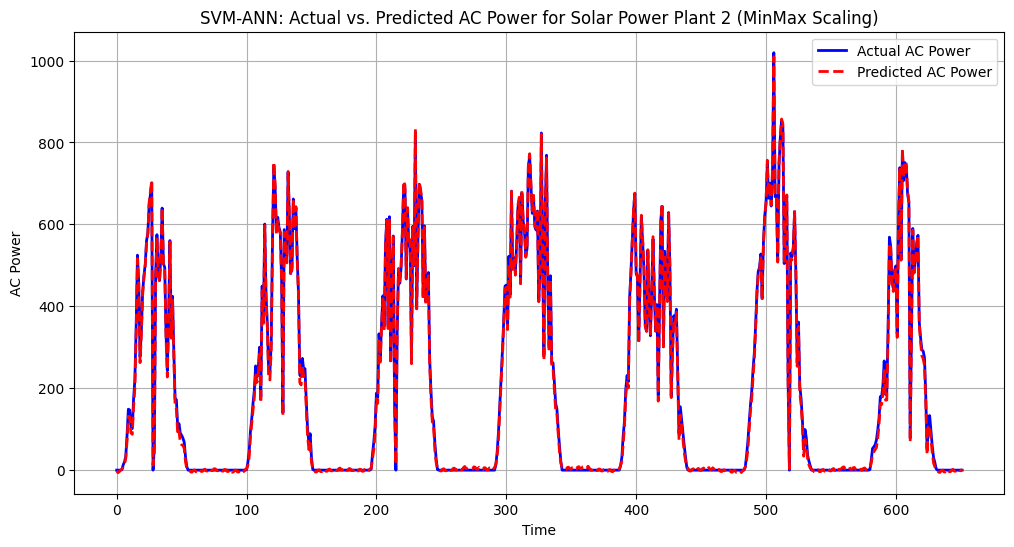

In [ ]:
# Step 1: Train an SVM Model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_model.fit(X_train2_minmax, y_train2_minmax.ravel())

# Step 2: Get Decision Function Outputs (New Features for ANN)
X_train_svm = svm_model.predict(X_train2_minmax).reshape(-1, 1)
X_test_svm = svm_model.predict(X_test2_minmax).reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_svm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train2_minmax, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_svm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test2_minmax, dtype=torch.float32)

# Step 3: Define ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize Model
input_dim = X_train_tensor.shape[1]
model = ANNModel(input_dim)

# Define Loss Function & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert data to device
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Step 4: Train ANN Model
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward Pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

# Step 5: Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert predictions back to original scale
y_pred_test = scalers["scaler_y2_minmax"].inverse_transform(y_pred_test.cpu().numpy())
y_test_actual = scalers["scaler_y2_minmax"].inverse_transform(y_test_tensor.cpu().numpy())

# Step 6: Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
mae = mean_absolute_error(y_test_actual, y_pred_test)
r2 = r2_score(y_test_actual, y_pred_test)

print(f"SVM-ANN Model Performance for Solar Power Plant 2 (MinMax Scaling):\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_pred_test, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVM-ANN: Actual vs. Predicted AC Power for Solar Power Plant 2 (MinMax Scaling)")
plt.grid(True)
plt.show()

**Support Vector Regression (SVR) Model:**

Standard Scaling:

In [ ]:
# Feature scaling

# Standard Scaling for Plant 1
scaler_x1_standard = StandardScaler()
X_train1_standard = scaler_x1_standard.fit_transform(X_train1)
X_test1_standard = scaler_x1_standard.transform(X_test1)

scaler_y1_standard = StandardScaler()
y_train1_standard = scaler_y1_standard.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_standard = scaler_y1_standard.transform(y_test1.values.reshape(-1, 1))

SVR Model Performance for Solar Power Plant 1 (Standard Scaling):
RMSE: 2.01, MAE: 1.71, R²: 1.00


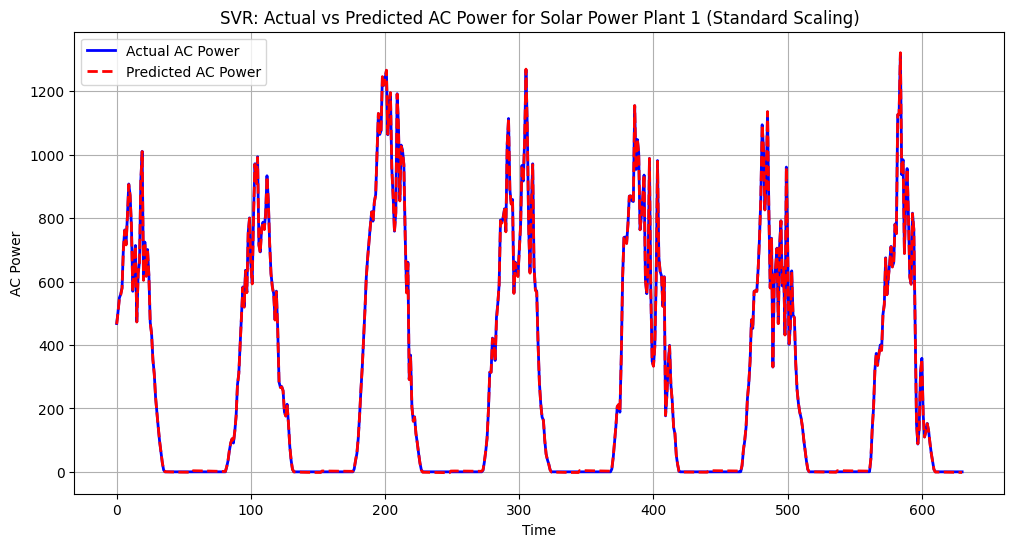

In [ ]:
# Define and Train SVR Model (Linear Kernel)
svr_linear = SVR(kernel='linear', C=100, epsilon=0.01)
svr_linear.fit(X_train1_standard, y_train1_standard)
y_pred_linear = svr_linear.predict(X_test1_standard)

# Predict on Train and Test Sets
y_train_pred_standard = svr_linear.predict(X_train1_standard)
y_test_pred_standard = svr_linear.predict(X_test1_standard)

# Inverse Transform Predictions
y_train_pred_actual = scaler_y1_standard.inverse_transform(y_train_pred_standard.reshape(-1, 1))
y_test_pred_actual = scaler_y1_standard.inverse_transform(y_test_pred_standard.reshape(-1, 1))

# Compute Performance Metrics
rmse = np.sqrt(mean_squared_error(y_test1, y_test_pred_actual))
mae = mean_absolute_error(y_test1, y_test_pred_actual)
r2 = r2_score(y_test1, y_test_pred_actual)

print(f"SVR Model Performance for Solar Power Plant 1 (Standard Scaling):")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test1.values, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_test_pred_actual, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVR: Actual vs Predicted AC Power for Solar Power Plant 1 (Standard Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# Standard Scaling for Plant 2
scaler_x2_standard = StandardScaler()
X_train2_standard = scaler_x2_standard.fit_transform(X_train2)
X_test2_standard = scaler_x2_standard.transform(X_test2)

scaler_y2_standard = StandardScaler()
y_train2_standard = scaler_y2_standard.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_standard = scaler_y2_standard.transform(y_test2.values.reshape(-1, 1))

SVR Model Performance for Solar Power Plant 2 (Standard Scaling):
RMSE: 2.27, MAE: 2.05, R²: 1.00


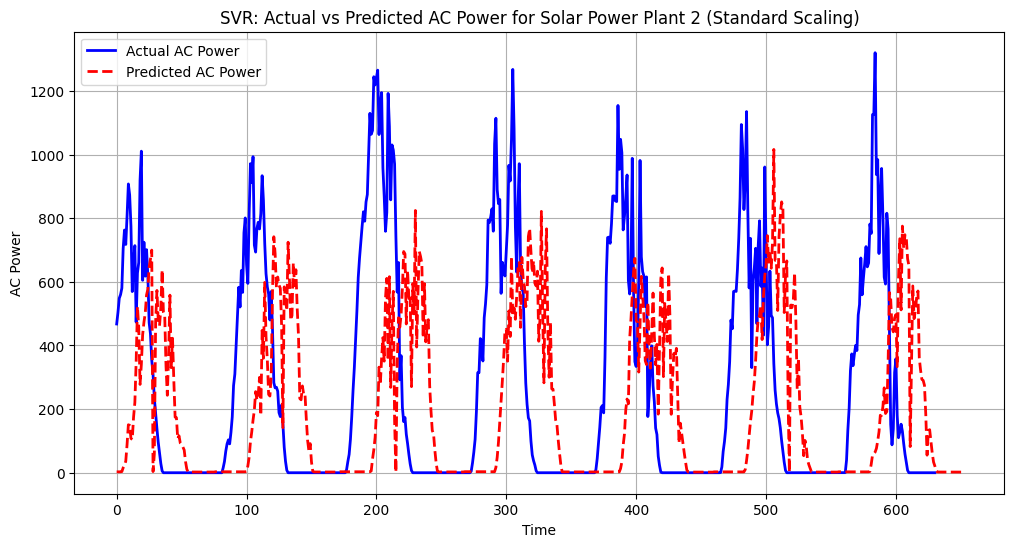

In [ ]:
# Define and Train SVR Model (Linear Kernel)
svr_linear = SVR(kernel='linear', C=100, epsilon=0.01)
svr_linear.fit(X_train2_standard, y_train2_standard)
y_pred_linear = svr_linear.predict(X_test2_standard)

# Predict on Train and Test Sets
y_train_pred_standard = svr_linear.predict(X_train2_standard)
y_test_pred_standard = svr_linear.predict(X_test2_standard)

# Inverse Transform Predictions
y_train_pred_actual = scaler_y2_standard.inverse_transform(y_train_pred_standard.reshape(-1, 1))
y_test_pred_actual = scaler_y2_standard.inverse_transform(y_test_pred_standard.reshape(-1, 1))

# Compute Performance Metrics
rmse = np.sqrt(mean_squared_error(y_test2, y_test_pred_actual))
mae = mean_absolute_error(y_test2, y_test_pred_actual)
r2 = r2_score(y_test2, y_test_pred_actual)

print(f"SVR Model Performance for Solar Power Plant 2 (Standard Scaling):")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test1.values, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_test_pred_actual, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVR: Actual vs Predicted AC Power for Solar Power Plant 2 (Standard Scaling)")
plt.grid(True)
plt.show()

MinMax Scaling:

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 1
scaler_x1_minmax = MinMaxScaler()
X_train1_minmax = scaler_x1_minmax.fit_transform(X_train1)
X_test1_minmax = scaler_x1_minmax.transform(X_test1)

scaler_y1_minmax = MinMaxScaler()
y_train1_minmax = scaler_y1_minmax.fit_transform(y_train1.values.reshape(-1, 1))
y_test1_minmax = scaler_y1_minmax.transform(y_test1.values.reshape(-1, 1))

SVR Model Performance for Solar Power Plant 1 (MinMax Scaling):
RMSE: 8.14, MAE: 7.03, R²: 1.00


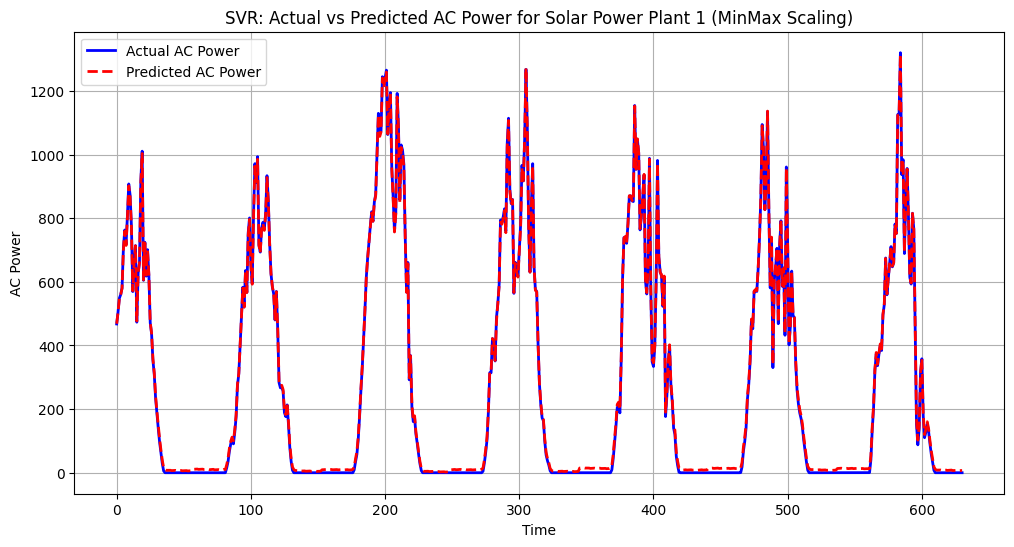

In [ ]:
# Define and Train SVR Model (Linear Kernel)
svr_linear = SVR(kernel='linear', C=100, epsilon=0.01)
svr_linear.fit(X_train1_minmax, y_train1_minmax)
y_pred_linear = svr_linear.predict(X_test1_minmax)

# Predict on Train and Test Sets
y_train_pred_minmax = svr_linear.predict(X_train1_minmax)
y_test_pred_minmax = svr_linear.predict(X_test1_minmax)

# Inverse Transform Predictions
y_train_pred_actual = scaler_y1_minmax.inverse_transform(y_train_pred_minmax.reshape(-1, 1))
y_test_pred_actual = scaler_y1_minmax.inverse_transform(y_test_pred_minmax.reshape(-1, 1))

# Compute Performance Metrics
rmse = np.sqrt(mean_squared_error(y_test1, y_test_pred_actual))
mae = mean_absolute_error(y_test1, y_test_pred_actual)
r2 = r2_score(y_test1, y_test_pred_actual)

print(f"SVR Model Performance for Solar Power Plant 1 (MinMax Scaling):")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test1.values, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_test_pred_actual, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVR: Actual vs Predicted AC Power for Solar Power Plant 1 (MinMax Scaling)")
plt.grid(True)
plt.show()

In [ ]:
# Feature scaling

# MinMax Scaling for Plant 2
scaler_x2_minmax = MinMaxScaler()
X_train2_minmax = scaler_x2_minmax.fit_transform(X_train2)
X_test2_minmax = scaler_x2_minmax.transform(X_test2)

scaler_y2_minmax = MinMaxScaler()
y_train2_minmax = scaler_y2_minmax.fit_transform(y_train2.values.reshape(-1, 1))
y_test2_minmax = scaler_y2_minmax.transform(y_test2.values.reshape(-1, 1))

SVR Model Performance for Solar Power Plant 2 (MinMax Scaling):
RMSE: 5.49, MAE: 4.50, R²: 1.00


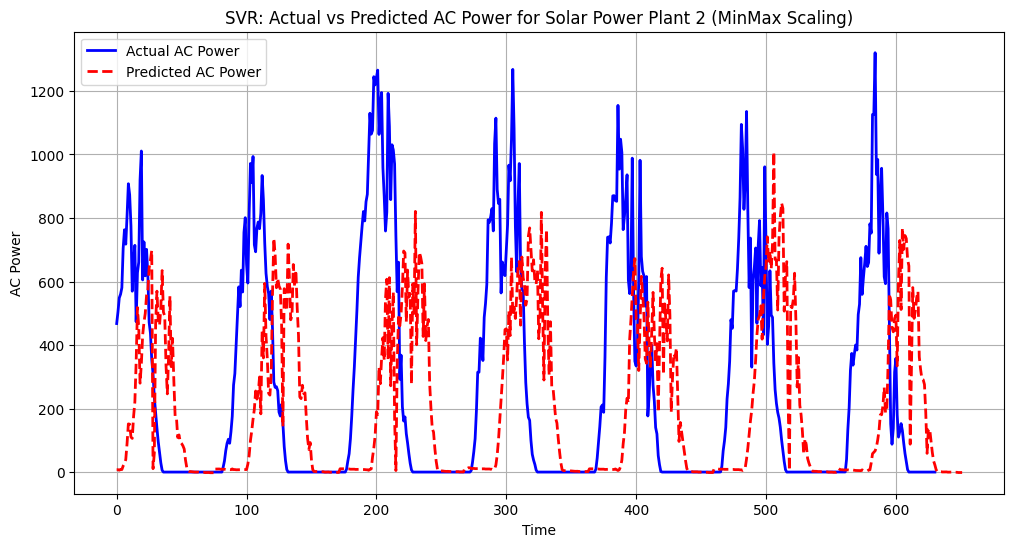

In [ ]:
# Define and Train SVR Model (Linear Kernel)
svr_linear = SVR(kernel='linear', C=100, epsilon=0.01)
svr_linear.fit(X_train2_minmax, y_train2_minmax)
y_pred_linear = svr_linear.predict(X_test2_minmax)

# Predict on Train and Test Sets
y_train_pred_minmax = svr_linear.predict(X_train2_minmax)
y_test_pred_minmax = svr_linear.predict(X_test2_minmax)

# Inverse Transform Predictions
y_train_pred_actual = scaler_y2_minmax.inverse_transform(y_train_pred_minmax.reshape(-1, 1))
y_test_pred_actual = scaler_y2_minmax.inverse_transform(y_test_pred_minmax.reshape(-1, 1))

# Compute Performance Metrics
rmse = np.sqrt(mean_squared_error(y_test2, y_test_pred_actual))
mae = mean_absolute_error(y_test2, y_test_pred_actual)
r2 = r2_score(y_test2, y_test_pred_actual)

print(f"SVR Model Performance for Solar Power Plant 2 (MinMax Scaling):")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test1.values, label="Actual AC Power", color='blue', linewidth=2)
plt.plot(y_test_pred_actual, label="Predicted AC Power", color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.legend()
plt.title("SVR: Actual vs Predicted AC Power for Solar Power Plant 2 (MinMax Scaling)")
plt.grid(True)
plt.show()